# Twitter trolls - how Russia meddles with western democracies


## Abstract
Over the last several years there has been an attempt from Russian trolls to spread propaganda and fake news over social media in order to spread political ideas among the general population both nationally and internationally. Can these attempts be regarded as undermining the democracy of the affected countries?

In this project we are going to analyze a great number of these russian tweets and look into their motivations for this meddling. We will look into their overall political operations in the US, and examine how these goals change over time. Have the trolls achieved their goals? We will also look into how the trolls operate and organize themselves, trying to find patterns in the madness. Such patterns can hopefully help the general population to indicate that a tweet is originating from a troll. As the Russian efforts are increasing every year, a solution is needed to defend the democracy.

### Imports used in this notebook


In [1]:
import pandas as pd
import numpy as np
from zipfile import ZipFile
import scipy as sp
from pyspark.sql import *
import matplotlib.pyplot as plt
from statistics import median 
#from langdetect import detect
%matplotlib inline
from datetime import datetime
from pyspark.sql.functions import *
from pyspark.sql.types import *
from matplotlib.pyplot import figure
#import pyspark.sql.SQLContext
from ipywidgets import *
import pyspark.sql.functions as func
import seaborn as sns
import plotly
plotly.tools.set_credentials_file(username='haakonms', api_key='oYz1dEh5JqxsGGF4EMQd')
import plotly.plotly as py
import plotly.graph_objs as go
%matplotlib inline
import warnings
#import findspark
#findspark.init()
warnings.filterwarnings('ignore')
#Want to ignore this since we had the same error running over and over regarding to whether use loc or make a copy. In our notebook the difference does not matter.

#spark = SparkSession.builder.getOrCreate()

# 1) Preprocessing the data
The data sets are of different shape and quality. The first one, provided by two researchers from Clemson University has already been preprocessed a bit. The second one is still quite raw, even though it has certain features as for example language. We have been cleaning some of it, and also processing and enriching to make new data frames that we want to use in our analysis.

## 1.1) The first dataset - IRA tweets from Kaggle.
The first dataset has the following features:
- external_author_id | An author account ID from Twitter 
- author | The handle sending the tweet
- content | The text of the tweet
- region | A region classification based on following criterias:
     - 1. Geographical coordinates
     - 2. Location listed in the user's profile
     - 3. Time zone set by the user in their Twitter account settings.
- language | The language of the tweet
- publish_date | The date and time the tweet was sent
- harvested_date | The date and time the tweet was collected by Social Studio
- following | The number of accounts the handle was following at the time of the tweet
- followers | The number of followers the handle had at the time of the tweet
- updates | The number of “update actions” on the account that authored the tweet, including tweets, retweets and likes
- post_type | Indicates if the tweet was a retweet or a quote-tweet
- account_type | Specific account theme, as coded by Linvill and Warren
- retweet | A binary indicator of whether or not the tweet is a retweet
- account_category` | General account theme, as coded by Linvill and Warren
- new_june_2018 | A binary indicator of whether the handle was newly listed in June 2018


### 1.1.1) Loading the first dataset
We loaded the 9 files into a unified dataframe. We decided to use pandas, since the dataset is not too large, and especially with the fact that we will be focusing on subsets of these tweets.

In [880]:
zip_file = ZipFile('russian-troll-tweets.zip')
data = pd.DataFrame()
for i in range(1,9):
    data = data.append(pd.read_csv(zip_file.open("IRAhandle_tweets_"+str(i)+".csv")))
first_set_data=data.reset_index()
first_set_data.tail(5)

,index,external_author_id,author,content,region,language,publish_date,harvested_date,following,followers,updates,post_type,account_type,new_june_2018,retweet,account_category
2935811,378290,1.513801e+09,YOUJUSTCTRLC,They'll say some shit anonymously like a cowar...,United States,English,1/7/2017 7:47,1/7/2017 7:48,2655,2724,3007,RETWEET,left,0,1,LeftTroll
2935812,378291,1.513801e+09,YOUJUSTCTRLC,Mr. Brown knees https://t.co/LmAiHCnFlz,United States,English,1/7/2017 7:47,1/7/2017 7:48,2655,2724,3006,RETWEET,left,0,1,LeftTroll
2935813,378292,1.513801e+09,YOUJUSTCTRLC,"Like, you want somebody who follows you regula...",United States,English,1/7/2017 7:47,1/7/2017 7:47,2655,2724,3005,RETWEET,left,0,1,LeftTroll
2935814,378293,1.513801e+09,YOUJUSTCTRLC,"If you wanna ask me something, ask it here so ...",United States,English,1/7/2017 7:48,1/7/2017 7:48,2655,2724,3008,RETWEET,left,0,1,LeftTroll
2935815,378294,1.513801e+09,YOUJUSTCTRLC,And there he is again ... Inside the KGB Playb...,United States,English,1/8/2017 1:56,1/8/2017 1:57,2655,2724,3013,RETWEET,left,0,1,LeftTroll


In [881]:
first_set_data.head(5)

,index,external_author_id,author,content,region,language,publish_date,harvested_date,following,followers,updates,post_type,account_type,new_june_2018,retweet,account_category
0,0,9.060000e+17,10_GOP,"""We have a sitting Democrat US Senator on tria...",Unknown,English,10/1/2017 19:58,10/1/2017 19:59,1052,9636,253,NaN,Right,0,0,RightTroll
1,1,9.060000e+17,10_GOP,Marshawn Lynch arrives to game in anti-Trump s...,Unknown,English,10/1/2017 22:43,10/1/2017 22:43,1054,9637,254,NaN,Right,0,0,RightTroll
2,2,9.060000e+17,10_GOP,Daughter of fallen Navy Sailor delivers powerf...,Unknown,English,10/1/2017 22:50,10/1/2017 22:51,1054,9637,255,RETWEET,Right,0,1,RightTroll
3,3,9.060000e+17,10_GOP,JUST IN: President Trump dedicates Presidents ...,Unknown,English,10/1/2017 23:52,10/1/2017 23:52,1062,9642,256,NaN,Right,0,0,RightTroll
4,4,9.060000e+17,10_GOP,"19,000 RESPECTING our National Anthem! #StandF...",Unknown,English,10/1/2017 2:13,10/1/2017 2:13,1050,9645,246,RETWEET,Right,0,1,RightTroll


### 1.1.2) Cleaning and filtering the first dataset
The first dataset is pretty clean as it is, but it contains some nan-values and duplicates. We are also working with some parts of the data set, so it's filtered a bit as well.

#### 1.1.2.1) Dropping the data we don't want.

The index column is unnecessary as pandas assigns an index anyway. "new_june_2018" and "harvested_date" does not add anything that we are going to use, and we already have a "post_type", so we don't need a binary indicator for that.

In [882]:
data1_drop_step = first_set_data.drop(columns=["retweet", "index", "new_june_2018", "harvested_date"]) 

#### 1.1.2.2) Filtering out the english tweets.
After inspecting some of the tweets we concluded that a lot of the language stamps do not match the actual tweets. For instance, most of the tweets labeled to our mothertongue Norwegian was English. The same went for different languages, such as those of neighbouring countries like Danish and Swedish. For this reason we decide to discard all tweets in other languages than english, in order to avoid confusion. We could have included tweets in other languages of which we have some knowledge of, we decide not to as we have limited knowledge of the political climate in these countries. The labeling of english tweets are also better, and our decision also helps keeping the scope of the project limited.

In [883]:
data1_filter_english = data1_drop_step.loc[data1_drop_step['language'] == "English"]
data1_filter_english.head(3)

,external_author_id,author,content,region,language,publish_date,following,followers,updates,post_type,account_type,account_category
0,9.060000e+17,10_GOP,"""We have a sitting Democrat US Senator on tria...",Unknown,English,10/1/2017 19:58,1052,9636,253,NaN,Right,RightTroll
1,9.060000e+17,10_GOP,Marshawn Lynch arrives to game in anti-Trump s...,Unknown,English,10/1/2017 22:43,1054,9637,254,NaN,Right,RightTroll
2,9.060000e+17,10_GOP,Daughter of fallen Navy Sailor delivers powerf...,Unknown,English,10/1/2017 22:50,1054,9637,255,RETWEET,Right,RightTroll


#### 1.1.2.3) Cleaning empty data and duplicates, plus some small format changes.

In [884]:
isna_columns = data1_filter_english.isna().any(axis=0)
column_nan_list = isna_columns[isna_columns== True].index.tolist()
for x in column_nan_list:
    print(x, ":", data1_filter_english[x].isnull().sum())
    #clean

content : 1
region : 1145
post_type : 1270631
account_type : 354


For content we are going to eliminate the only empty one. For region and account_type, we are going to change it to an string that shows that it is unknown. When the post_type is nan, it only means that it is a original tweet so we change it to that.

In [885]:
data1_filter_english["account_type"] = data1_filter_english["account_type"].fillna("?") #gjøre om right til Right?
data1_filter_english["region"] = data1_filter_english["region"].fillna("Unknown")
data1_filter_english["content"] = data1_filter_english["content"].dropna()
data1_filter_english["post_type"] = data1_filter_english["post_type"].fillna("ORIGINAL")
#clea


In [886]:
#We also found out that there are two account_types that are equal. "Right" and "right". T
data1_filter_english["account_type"] = data1_filter_english["account_type"].str.lower()


The time stamps in this dataset is in string format. For further calculations, it would be better to have them as datetime.

In [887]:
data1_filter_english["publish_date"] = pd.to_datetime(data1_filter_english["publish_date"], format='%m/%d/%Y\n%H:%M')

In [888]:
data1_dup_step = data1_filter_english.drop_duplicates()
duplicates_number = data1_filter_english.shape[0]-data1_dup_step.shape[0] 
#drop duplicates in everything
dropdup_specific = data1_filter_english.drop_duplicates(subset= ["external_author_id", "content", "following", "followers", "updates", "post_type"])
duplicates_except_timestamp = data1_dup_step.shape[0]-dropdup_specific.shape[0]
print("Full duplicates:", duplicates_number, "\nDuplicates in all forms except time stamp:", duplicates_except_timestamp)

Full duplicates: 13692 
Duplicates in all forms except time stamp: 358


In [889]:
data_sub_dropped = data1_filter_english.drop_duplicates(subset= ["external_author_id", "content", "following", "followers", "updates", "post_type"])

The creators of this dataset also states that they did not sample anything in 2018. There are still a few tweets that have slipped in with the date tag being 2018. These are in so few numbers so we limit our data set to the period before that.

In [890]:
data1 = data_sub_dropped.loc[data_sub_dropped["publish_date"] < "2018-01-01"]
data1.head(5)

,external_author_id,author,content,region,language,publish_date,following,followers,updates,post_type,account_type,account_category
0,9.060000e+17,10_GOP,"""We have a sitting Democrat US Senator on tria...",Unknown,English,2017-10-01 19:58:00,1052,9636,253,ORIGINAL,right,RightTroll
1,9.060000e+17,10_GOP,Marshawn Lynch arrives to game in anti-Trump s...,Unknown,English,2017-10-01 22:43:00,1054,9637,254,ORIGINAL,right,RightTroll
2,9.060000e+17,10_GOP,Daughter of fallen Navy Sailor delivers powerf...,Unknown,English,2017-10-01 22:50:00,1054,9637,255,RETWEET,right,RightTroll
3,9.060000e+17,10_GOP,JUST IN: President Trump dedicates Presidents ...,Unknown,English,2017-10-01 23:52:00,1062,9642,256,ORIGINAL,right,RightTroll
4,9.060000e+17,10_GOP,"19,000 RESPECTING our National Anthem! #StandF...",Unknown,English,2017-10-01 02:13:00,1050,9645,246,RETWEET,right,RightTroll


This dataset is ready to go!

## 1.2) The second dataset
Twitter released nine million tweets that they had traced to russian troll accounts on 17th October 2018. This dataset was in a much more raw format than the one provided on Kaggle, and consisted of eigth csv-files. Four of them was tweets from the Iranian agency, who also does this on a major scale. The other four was tweets produced by the IRA:
- rus_troll_user.csv : Contains user specific features. 
- rus_troll_tweet_text.csv: Contains text and language of the given tweet.
- rus_troll_tweet_metadata.csv: Contains features that are user specific, but may change tweet to tweet.
- rus_troll_tweet_stats.csv: Contains other tweet features like retweet count, like count, if it is a retweet, quote tweet etc.

The whole dataset can be downloaded at this link: https://drive.google.com/open?id=1GBsVXYvPrGcYI-wR4mWGO39fly1TMqjO.

When we worked with this we split it up in one frame that we merged together, removing a lot of unnecessary columns, and we also did parts where we kept the original content of it.

### 1.2.1) Loading the second dataset
We loaded the second dataset in as pandas data frames as well. After that we merged all of them together and created a new one for our preliminary analysis. For our research question we used the original format of it as mentioned in the markdown cell under.

In [158]:
testi = new_stats[["in_reply_to_tweetid", "quoted_tweet_tweetid"]].dropna()
new_stats.loc[testi.index]


,tweetid,userid,tweet_time,in_reply_to_tweetid,in_reply_to_userid,quoted_tweet_tweetid,is_retweet,retweet_userid,retweet_tweetid,quote_count,reply_count,like_count,retweet_count,hashtags,user_mentions
556,836395021637070848,a95a911dd6ae864c48ed062cdbe75e5c28dbe0cf57c6db...,2017-02-28 01:58,8.362255e+17,627053327,8.363941e+17,False,NaN,NaN,0,0,0,0,[],[627053327]
560,836794680096526341,a95a911dd6ae864c48ed062cdbe75e5c28dbe0cf57c6db...,2017-03-01 04:26,8.367861e+17,1720816128,8.367934e+17,False,NaN,NaN,0,0,0,0,[],[1720816128]
640,934698263139061761,a95a911dd6ae864c48ed062cdbe75e5c28dbe0cf57c6db...,2017-11-26 08:20,9.346251e+17,19372504,9.343111e+17,False,NaN,NaN,0,0,0,0,[],"[19372504, 822215679726100480, 2746979823]"
1553,939056049138442240,a95a911dd6ae864c48ed062cdbe75e5c28dbe0cf57c6db...,2017-12-08 08:56,9.390253e+17,791398287215566848,9.390543e+17,False,NaN,NaN,0,0,1,0,[],"[791398287215566848, 25073877]"
1636,932307616088317952,a95a911dd6ae864c48ed062cdbe75e5c28dbe0cf57c6db...,2017-11-19 18:00,9.320958e+17,3297022953,9.316945e+17,False,NaN,NaN,0,0,1,0,[],"[3297022953, 396046166]"
2329,932376708472299520,a95a911dd6ae864c48ed062cdbe75e5c28dbe0cf57c6db...,2017-11-19 22:35,9.323383e+17,457984599,9.316945e+17,False,NaN,NaN,0,0,0,0,[],[457984599]
2345,932507134452908033,a95a911dd6ae864c48ed062cdbe75e5c28dbe0cf57c6db...,2017-11-20 07:13,9.324983e+17,20812660,9.316945e+17,False,NaN,NaN,0,0,1,1,[],"[20812660, 39308549]"
4652,932150952810889218,a95a911dd6ae864c48ed062cdbe75e5c28dbe0cf57c6db...,2017-11-19 07:38,9.320807e+17,4152518164,9.316945e+17,False,NaN,NaN,0,0,0,0,[],[4152518164]
4662,932129395036188672,a95a911dd6ae864c48ed062cdbe75e5c28dbe0cf57c6db...,2017-11-19 06:12,9.320095e+17,779066700490682368,9.316945e+17,False,NaN,NaN,0,0,0,0,[],"[779066700490682368, 889982846428782592]"
4735,935376673809219584,a95a911dd6ae864c48ed062cdbe75e5c28dbe0cf57c6db...,2017-11-28 05:15,9.353639e+17,706959926879334400,9.343111e+17,False,NaN,NaN,0,0,0,0,[],[706959926879334400]


In [33]:
zip_file_new = ZipFile("New_russian_tweets.zip")
new_text = pd.read_csv(zip_file_new.open("rus_troll_tweet_text.csv"))
new_metadata = pd.read_csv(zip_file_new.open("rus_troll_tweet_metadata.csv")).drop(columns=["latitude","longitude","tweet_client_name"])
new_user = pd.read_csv(zip_file_new.open("rus_troll_user.csv")).drop(columns=["user_display_name","user_screen_name","user_profile_description","user_profile_url"])
new_stats = pd.read_csv(zip_file_new.open("rus_troll_tweet_stats.csv")).drop(columns=["poll_choices","urls"])

When we first worked with the second dataset for milestone 2, we were not sure what to do with it. When performing further analysis after milestone 2 we wanted to use the original files in spark, so we wrote them to parquet and loaded them back.

In [15]:
#data2.to_parquet('data2.parquet.gzip', compression='gzip')
#new_stats.to_parquet('stats.parquet.gzip', compression='gzip')
#new_tweets.to_parquet('tweets.parquet.gzip', compression='gzip')
#new_text.to_parquet('text.parquet.gzip', compression='gzip')
#new_user.to_parquet('user.parquet.gzip', compression='gzip')
#This cell need to be run if you don't have these files.

In [6]:
#tweets = spark.read.parquet('tweets.parquet.gzip')
text = spark.read.parquet('text.parquet.gzip')
stats = spark.read.parquet('stats.parquet.gzip')
users = spark.read.parquet('user.parquet.gzip')


### 1.2.2) Cleaning, merging and filtering the second dataset

The data set did not have suitable column names, so we manually created column names under. We also merged all of the different files together, since we had dropped a bunch of columns which we found unnecessary for the first analysis. 

In [34]:
new_english_text = new_text[new_text["tweet_language"]=="en"].drop(columns=["tweet_language"])
#To create a data frame that only had english tweets in it.
new_metadata.columns=["tweetid","following","followers"]

In [35]:
merge_step = pd.merge(new_english_text, new_metadata, on='tweetid')
new_tweets = pd.merge(merge_step,new_stats.filter(["tweetid","userid","tweet_time"]) , on='tweetid')

In the first data set we had a column that showed whether the tweet was original, retweet etc. The second set had not the same features, so we wanted to create this. 

In [36]:
#we sort out retweets from one set
retweets = new_stats[new_stats["is_retweet"]==True]
#Select retweets in tweet set
retweets = new_tweets[new_tweets["tweetid"].isin(retweets["tweetid"].tolist())]
#add extra column stating that this is a retweet
retweets["post_type"] ="RETWEET"
#We follow same procedure for quote tweets, after finding tweets with quoted tweetid
quote_tweets = new_stats[np.isfinite(new_stats['quoted_tweet_tweetid'])]
quote_tweets = new_tweets[new_tweets["tweetid"].isin(quote_tweets["tweetid"].tolist())]
#we only regard a retweeted quotetweet as a retweet
quote_tweets = quote_tweets[~quote_tweets["tweetid"].isin(retweets["tweetid"].tolist())]
quote_tweets["post_type"] = "QUOTE_TWEET"
unoriginal_tweets = quote_tweets.append(retweets)
#we label all other tweets as original tweets
orig_tweets= new_tweets[~new_tweets["tweetid"].isin(unoriginal_tweets["tweetid"])]
orig_tweets["post_type"] = "ORIGINAL"
data2 = unoriginal_tweets.append(orig_tweets)
data2.head(5)

,tweetid,tweet_text,following,followers,userid,tweet_time,post_type
12,653251376760295425,I need this skill https://t.co/2X4DHRVp2W,22035,9795,2882350436,2015-10-11 16:50,QUOTE_TWEET
42,748448356297498626,Getting richer will provide our communities mo...,20019,14112,3978316814,2016-06-30 09:29,QUOTE_TWEET
199,815037019973763073,Can't blame @realDonaldTrump for blocking you!...,2748,265,a95a911dd6ae864c48ed062cdbe75e5c28dbe0cf57c6db...,2016-12-31 03:29,QUOTE_TWEET
277,805940400229740545,"Damn, look at disgusting fatass @CBRangel... h...",2748,265,a95a911dd6ae864c48ed062cdbe75e5c28dbe0cf57c6db...,2016-12-06 01:02,QUOTE_TWEET
346,786297829459308544,4 days and 5 hours left! Take the poll! http...,2748,265,a95a911dd6ae864c48ed062cdbe75e5c28dbe0cf57c6db...,2016-10-12 20:09,QUOTE_TWEET


The second dataset now have the following features: 
- tweetid | The ID of the tweet.
- tweet_text | The text of the tweet 
- tweet_time | The date and time the tweet was sent
- following | The number of accounts the handle was following at the time of the tweet
- followers | The number of followers the handle had at the time of the tweet
- user_id | The unique ID of the user who posted the tweet.
- post_type | Indicates if the tweet was a retweet, original tweet or a quote-tweet.


# 2) An overview of the data.

## 2.1) Enriching the data

We want to enrich the data set by making some new frames for possible use, where we also are going to add some new features. As follows:

#### Authors
There are 2.1 million english tweets in this dataset but only a number of unique usernames. We want to take a look at who the unique authors are, what category they are and how they became so prominent. 

In [893]:
authors_step = data1[["external_author_id", "author", "account_category"]].drop_duplicates(subset = ["external_author_id", "author"])
authors = authors_step[authors_step.account_category != "NonEnglish"]
authors["tweet_count"] = data1.groupby('author')['author'].transform('count')
authors["peak_followers"] = data1.groupby(['author'], sort=True)['followers'].transform("max")
rtcountstep = data1[data1["post_type"] == "RETWEET"]["author"].value_counts().to_frame()
authors = rtcountstep.merge(authors, right_on = "author", left_on = rtcountstep.index, how= "right").fillna(0)
authors = authors.drop(columns="author_y").drop_duplicates(subset = ["tweet_count", "author", "peak_followers", "author_x"])
authors = authors.rename(index=str, columns={"author_x": "retweet_count"})



In [28]:
most_pop_authors = authors.sort_values(by = "peak_followers", axis = 0)
most_pop_authors.tail(10)

,author,retweet_count,external_author_id,account_category,tweet_count,peak_followers
384,BLACKNEWSOUTLET,42.0,4.301963e+09,LeftTroll,2482,40788
181,THEFOUNDINGSON,951.0,4.508631e+09,RightTroll,8798,42000
253,USA_GUNSLINGER,281.0,4.332741e+09,RightTroll,3234,43895
292,SOUTHLONESTAR,151.0,4.355797e+09,RightTroll,3647,53782
212,CRYSTAL1JOHNSON,624.0,4.437234e+09,LeftTroll,8037,56725
492,ELEVEN_GOP,20.0,4.218156e+09,RightTroll,101,59100
524,TODAYNYCITY,17.0,2.752678e+09,NewsFeed,18478,62088
237,PAMELA_MOORE13,361.0,4.272871e+09,RightTroll,6197,70734
215,JENN_ABRAMS,596.0,2.882332e+09,RightTroll,22512,71022
201,TEN_GOP,769.0,4.224730e+09,RightTroll,11274,145244


In [29]:
most_active_authors = authors.sort_values(by = "tweet_count", axis = 0)#.drop_duplicates(subset = ["author", "account_category", "tweet_count", "peak_followers"])
#For some reason, the author with the most tweets appeared with two different author IDs, and every other column was equal.
most_active_authors.tail(5)

,author,retweet_count,external_author_id,account_category,tweet_count,peak_followers
465,TODAYPITTSBURGH,25.0,2.601236e+09,NewsFeed,33376,20608
0,AMELIEBALDWIN,32780.0,1.679279e+09,RightTroll,34307,2860
1361,WORLDNEWSPOLI,0.0,7.890000e+17,RightTroll,35082,3855
1319,SCREAMYMONKEY,0.0,2.943515e+09,NewsFeed,43685,13295
1160,EXQUOTE,0.0,1.964340e+09,Commercial,53158,858


#### Data sets tailored for specific themes.

In [30]:
data1_political = data1[data1["account_category"].isin(["RightTroll","LeftTroll","NewsFeed"])]
data1_political.head(4)

,external_author_id,author,content,region,language,publish_date,following,followers,updates,post_type,account_type,account_category
0,9.060000e+17,10_GOP,"""We have a sitting Democrat US Senator on tria...",Unknown,English,2017-10-01 19:58:00,1052,9636,253,ORIGINAL,right,RightTroll
1,9.060000e+17,10_GOP,Marshawn Lynch arrives to game in anti-Trump s...,Unknown,English,2017-10-01 22:43:00,1054,9637,254,ORIGINAL,right,RightTroll
2,9.060000e+17,10_GOP,Daughter of fallen Navy Sailor delivers powerf...,Unknown,English,2017-10-01 22:50:00,1054,9637,255,RETWEET,right,RightTroll
3,9.060000e+17,10_GOP,JUST IN: President Trump dedicates Presidents ...,Unknown,English,2017-10-01 23:52:00,1062,9642,256,ORIGINAL,right,RightTroll


#### Data frames with different time periods

Here we will be making some data frames used for the task 3.2. 

The first person that entered and started the primaries was Ted Cruz who officially entered the campaign on th 23th of March 2015. Hillary joined in as the first Democratic candidat on 12th April 2015. Donald Trump announced his candidacy on 16th June 2015.

Therefore it is interesting to look at the amount of tweets from each side, starting with Ted Cruz' announcement. We have been looking into which party that has seen the most meddling, building up to the first primaries, the period between primaries and election and after the election. 

In [31]:
before_primaries1 = data1.loc[data1["publish_date"] < "2016-06-14"]
before_primaries1 = before_primaries1.loc[before_primaries1["publish_date"] > "2015-03-23"]
before_primaries_time1 = before_primaries1["publish_date"].map(lambda x: str(x)[:7]).value_counts()
#left
before_primaries_left1 = before_primaries1.loc[before_primaries1["account_type"] == "left"]
bp_left_count1 = before_primaries_left1["publish_date"].map(lambda x: str(x)[:7]).value_counts()
#right
before_primaries_right1 = before_primaries1.loc[before_primaries1["account_type"] == "right"]
bp_right_count1 = before_primaries_right1["publish_date"].map(lambda x: str(x)[:7]).value_counts()


After the primaries, things changed. Now it was a run between Clinton and Trump.

In [32]:
after_primaries1 = data1.loc[data1["publish_date"] > "2016-06-14"]
after_primaries_time1 = after_primaries1["publish_date"].map(lambda x: str(x)[:7]).value_counts()
#left
after_primaries_left1 = after_primaries1.loc[after_primaries1["account_type"] == "left"]
ap_left_count1 = after_primaries_left1["publish_date"].map(lambda x: str(x)[:7]).value_counts()
#right
after_primaries_right1 = after_primaries1.loc[after_primaries1["account_type"] == "right"]
ap_right_count1 = after_primaries_right1["publish_date"].map(lambda x: str(x)[:7]).value_counts()

As mentioned, these frames are made for the analysis in part 3.2, and they will be used and visualized in that part.

## 2.2) Key takeaways from the data.

### 2.2.1 Tweets over time

#### 2.2.1.1 First data set
How many tweets have been tweeted each month since the first russian troll tweet? 

In [33]:
early_tweets1 = data1[data1["publish_date"] < "2014-10"]
early_tweets1.shape[0]

197

Since there are only 197 tweets before october 2014, we remove these from the visualisation since the other numbers are so much higher.

In [9]:
def name_axises(title, xlab, ylab):
    plt.title(title, size=22), plt.xlabel(xlab, size=20), plt.ylabel(ylab, size=20)
# A function for future plotting to save some lines.


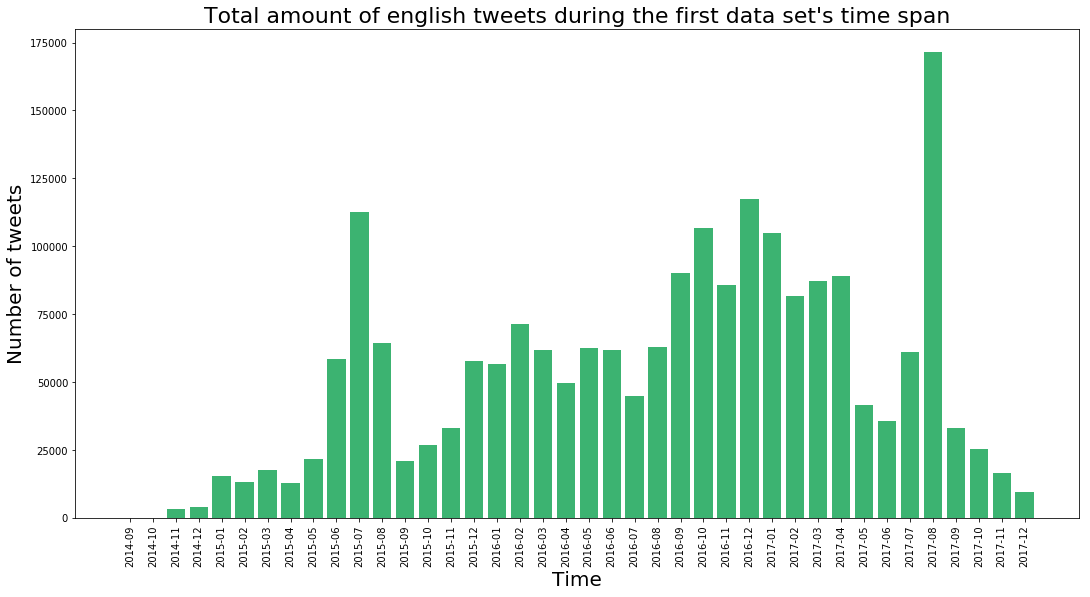

In [34]:
data1_timesorted = data1[data1["publish_date"] > "2014-09"].sort_values("publish_date")
data1_month_days = data1_timesorted["publish_date"].map(lambda x: str(x)[:7])
#if we want only month and days. 
data1_month_count = data1_month_days.value_counts()

fig, ax = plt.subplots(1,1 , figsize =(18,9))
over_time_fig = plt.bar(data1_month_count.index, data1_month_count, color = "#3CB371", align="center")
ax.set_xticklabels(data1_month_count.sort_index().index, rotation=90)
name_axises("Total amount of english tweets during the first data set's time span", "Time", "Number of tweets")

The results shows that there were almost no activity until the announcement of the first candidacies in the primaries, with the first visible chart in november 2014. Activity increased in the months just before the election, peaked in december 2016 and decreased a little after that. There were two spikes in July 2015 and August 2017. In August 2017 this was probably because of the Unite The Right rally in Charlottesville, also known as the Charlottesville riots (https://en.wikipedia.org/wiki/Unite_the_Right_rally) (https://buzzfeednews.github.io/2018-08-charlottesville-twitter-trolls/), where e.g. a woman got killed by a white supremacist. 

With the spike in July 2015 we can see in the other dataset that this is not an unique spike but a common number for this period. The first dataset has just not picked so many of the troll tweets before this. 

It is difficult to say whether this represents all the russian troll tweets in this period can amount for the same activity, especially when it comes to the final months of the sample. It could still be viewed as a trend. 

#### 2.2.1.2 Second dataset

In [28]:
early_tweets = data2[data2["tweet_time"] < "2013-11"]
early_tweets.shape[0]

418

As with the first dataset we remove the posts before november 2013 because there are only 418 of them.

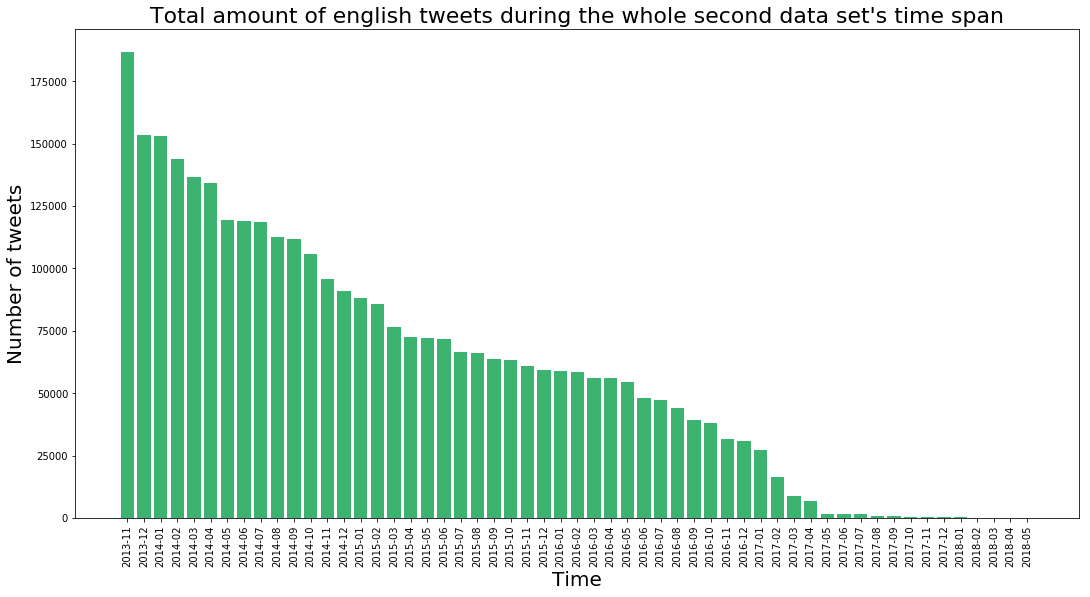

In [29]:
data2_timesorted = data2[data2["tweet_time"] > "2013-10-31"].sort_values("tweet_time")
data2_month_days = data2_timesorted["tweet_time"].map(lambda x: str(x)[:7])
#if we want only month and days. 
data2_month_count = data2_month_days.value_counts()

fig, ax = plt.subplots(1,1 , figsize =(18,9))
over_time_fig = plt.bar(data2_month_count.index, data2_month_count, color = "#3CB371", align="center")
ax.set_xticklabels(data2_month_count.sort_index().index, rotation=90)
name_axises("Total amount of english tweets during the whole second data set's time span", "Time", "Number of tweets")

Almost all the tweets from the first dataset are also in the second dataset. When comparing the two against each other, notice that the labels on thex-axis are different for them. Here we can see that this dataset is quite similar to first one in 2016 and further, but before this point this set has catched up a lot more. For example august 2014 has almost 150000 tweets, and in the first dataset this number is almost non-existent.

These two first visualisations are both tweets with only english language. Under follows a visualisation of all types of language, where we have filtered out the tweets before 2012, since they have a very small fraction of the total tweets and is not visible.

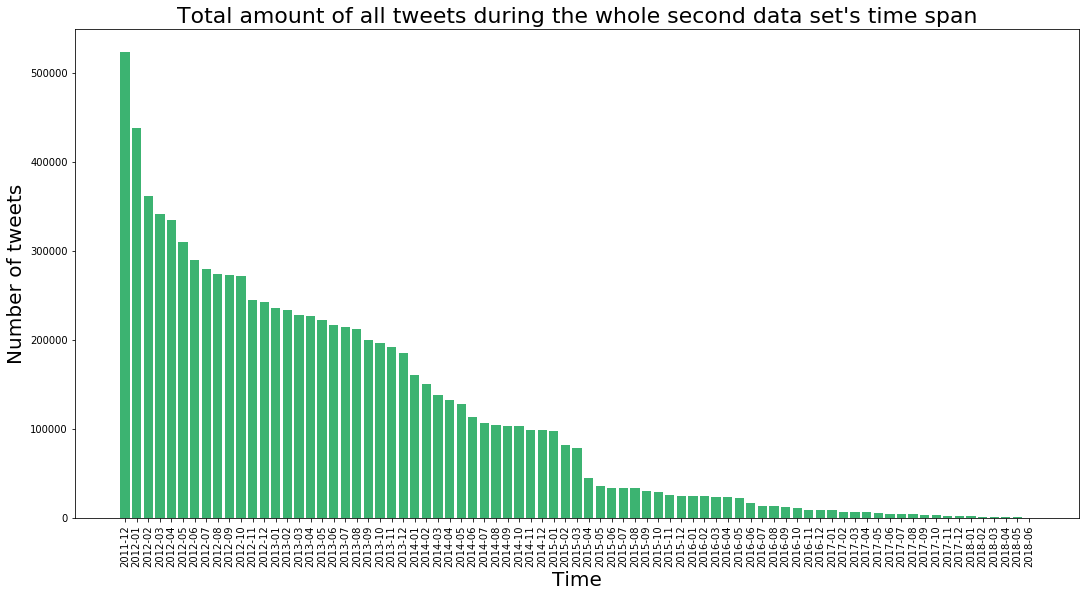

In [30]:
data2_all = new_stats[new_stats["tweet_time"]> "2011-12"].sort_values("tweet_time")
data2all_month_days = data2_all["tweet_time"].map(lambda x: str(x)[:7])
#if we want only month and days. 
data2all_month_count = data2all_month_days.value_counts()

fig, ax = plt.subplots(1,1 , figsize =(18,9))
over_time_fig = plt.bar(data2all_month_count.index, data2all_month_count, color = "#3CB371", align="center")
ax.set_xticklabels(data2all_month_count.sort_index().index, rotation=90)
name_axises("Total amount of all tweets during the whole second data set's time span", "Time", "Number of tweets")

Here we can see that the most tweets actually appeared in 2014. There is a difference here, that most of these tweets are in russian. Before the english tweets really sparked off, there were a lot of russian tweets. This was in the period when the Ukrainian-Russian war/military interference was often mentioned in the media. It may be that the success of the tweeting in this period also started the activity in other regions. This is only speculations, but one thing can be said for sure: The russian trolls came before the english ones. 

### 2.2.2 First appearances of users

We also take a look at when each user accounts had their first entries in the dataset. This may explain why there are more or fewer tweets in the different months of the span of the total number of tweets. 

Disclaimer: This analysis is just of users that at some time have tweeted in the language English. Their account category may be NonEnglish, but they have also at some point had content in english.

#### 2.2.2.1 First dataset

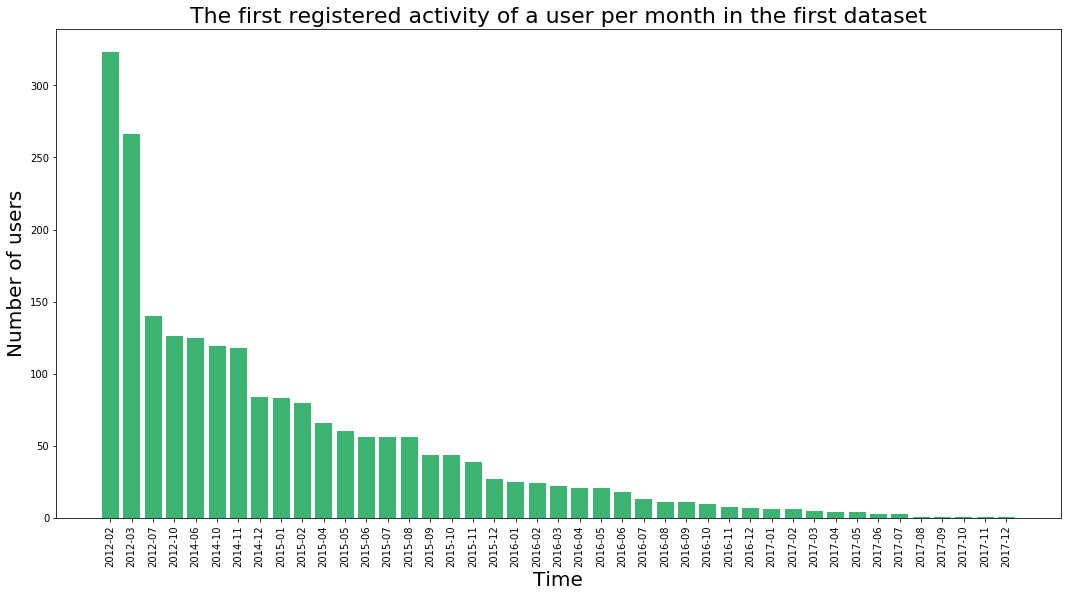

In [31]:
#Create table for first registered user activity
useropening = data1.sort_values(["author", "publish_date"])[["author", "publish_date", "account_category", "external_author_id"]].drop_duplicates(subset=["external_author_id", "author"]).drop(columns=["external_author_id"])
useropening.sort_values("publish_date")
uo = useropening["publish_date"].map(lambda x: str(x)[:7]).value_counts()

fig, ax = plt.subplots(1,1, figsize =(18,9))
Firstappearing = plt.bar(uo.index, uo, color = "#3CB371", align="center")
ax.set_xticklabels(uo.sort_index().index, rotation=90)
name_axises("The first registered activity of a user per month in the first dataset", "Time", "Number of users")

We can see here that most of the users first appeare in 2015, after the primaries had started, and with a little spike in the summer of 2017, which can explain a part of why the number of tweets increased. NB: Pay attention to the labels on the x-axis. Months with no introduction of new users are not included in this visualisation.

Why there are almost no tweets in the first dataset before november 2014 in the timeline is because there was almost none active troll users in that period. As we can see in the table provided under, the first entry of only ten users was registered before this time. Half of them was in the month before, and before that it looks sporadic with none users first entried in the year 2013.

In [891]:
earlydaysvisual = data1[data1["publish_date"] < "2014-11-01 00:00:00"][["author", "publish_date", "account_category"]].sort_values("publish_date").drop_duplicates(subset="author")
trace = go.Table(
    header=dict(values=['Author', 'Account Category', 'First entry in dataset'],
                line = dict(color='#7D7F80'),
                fill = dict(color='#a1c3d1'),
                align = ['left'] * 5),
    cells=dict(values=[earlydaysvisual["author"], earlydaysvisual["account_category"],
                      earlydaysvisual["publish_date"]],
               line = dict(color='#7D7F80'),
               fill = dict(color='#EDFAFF'),
               align = ['left'] * 5))
layout = dict(width=800, height=500)
data = [trace]
fig = dict(data=data, layout=layout)
py.iplot(fig, filename = 'styled_table')


Five of these authors were also first entried in october. Interestingly, none users in this data set had their first entry in 2013. 

Here is visualized the entries of the categories in each month:

In [33]:
#Here we make a table to count all the different entries of each user category per month.
cat_opening = useropening[["publish_date", "account_category"]]
cat_opening["publish_date"] = cat_opening["publish_date"].map(lambda x: str(x)[:7])
date_index = cat_opening[["publish_date"]].sort_values("publish_date").drop_duplicates().set_index("publish_date")
#add each category
date_index["left_count"] = cat_opening[cat_opening["account_category"] == "LeftTroll"]["publish_date"].value_counts()
date_index["right_count"] = cat_opening[cat_opening["account_category"] == "RightTroll"]["publish_date"].value_counts()
date_index["NonEnglish_count"] = cat_opening[cat_opening["account_category"] == "NonEnglish"]["publish_date"].value_counts()
date_index["Other_count"] = cat_opening.query('account_category != "LeftTroll" & account_category != "RightTroll" & account_category != "NonEnglish" ')["publish_date"].value_counts()
date_index["Total_count"] = cat_opening["publish_date"].value_counts()
date_index = date_index.fillna(0)

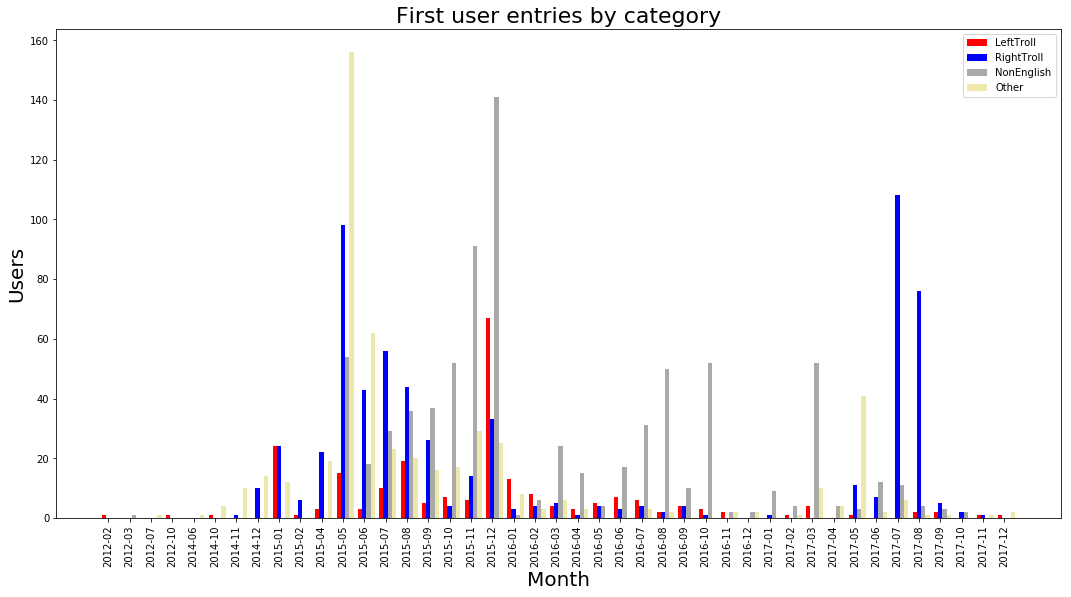

In [34]:
fig, ax = plt.subplots(1, 1, figsize=(18,9))
ax.set_xticklabels(date_index.index, rotation=90)
width = 0.2
ax.set_xticks(np.arange(43) + width)

rects1 = ax.bar(np.arange(43), date_index["left_count"], width, color='r', label='LeftTroll')
rects2 = ax.bar(np.arange(43) + width, date_index["right_count"], width, color='b', label='RightTroll')
rects3 = ax.bar(np.arange(43) + width*2, date_index["NonEnglish_count"], width, color='darkgrey', label='NonEnglish')
rects4 = ax.bar(np.arange(43) + width*3, date_index["Other_count"] , width, color='palegoldenrod', label='Other')


ax.legend()
name_axises("First user entries by category", "Month", "Users")

Most of the accounts were created over a time period in 2015. A few spike points stand out, for example we can see that many of the "other" accounts like NewsFeed and HashtagGamer were created in May 2015. The same month had a high spike of right troll tweets, but the highest amount of Right Trolls came in the summer of 2018, leading up to the events that we mentioned earlier. 

The NonEnglish users have had tweets in english, but generally tweet in another language. They can't be viewed as a repsentation of all the NonEnglish users, but are of the ones that have had tweets in english.

#### 2.2.2.2 Second dataset

In the second dataset we unfortunately don't have the account categories, so there are only going to be a visualisation of each user entry per month. This one is mostly for our data story.

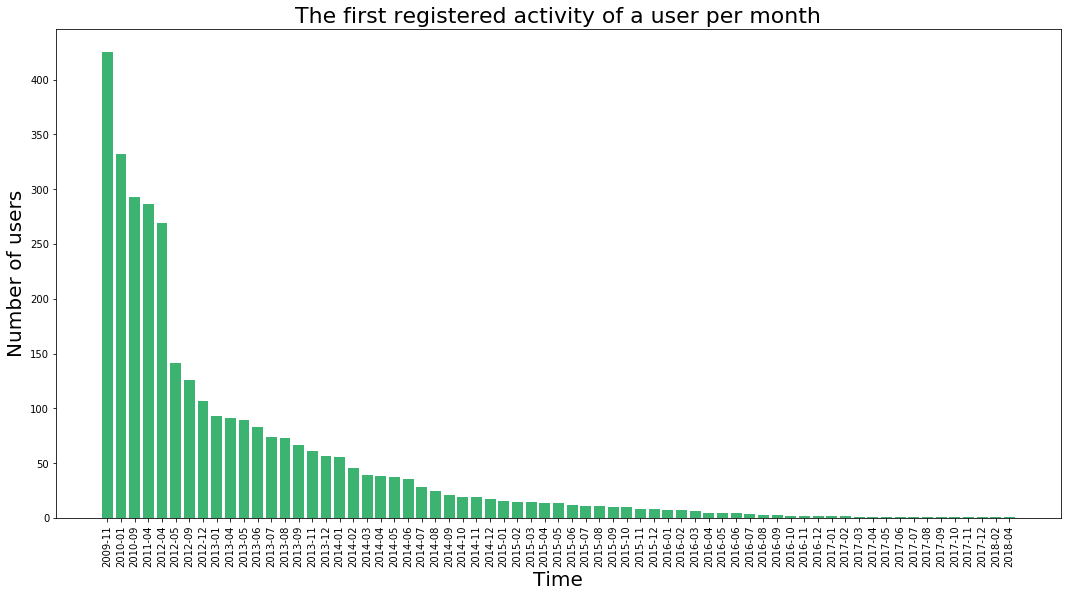

In [35]:
#Create table for first registered user activity
useropening2 = data2.sort_values(["userid", "tweet_time"])[["tweet_time", "userid"]].drop_duplicates(subset= "userid")
useropening2.sort_values("tweet_time")
uo2 = useropening2["tweet_time"].map(lambda x: str(x)[:7]).value_counts()

fig, ax = plt.subplots(1,1, figsize =(18,9))
Firstappearing = plt.bar(uo2.index, uo2, color = "#3CB371", align="center")
ax.set_xticklabels(uo2.sort_index().index, rotation=90)
name_axises("The first registered activity of a user per month", "Time", "Number of users")

In this dataset we have users being registered dating the whole way back to 2009, and also a extremely higher number of users that had their first tweets in 2014. This is the major difference between the two datasets: The number of users and tweets in 2014.

### 2.2.3 Tweets per day

What about the spread of tweets throughout a day? May it be possible to detect some irregularities regarding the time differences between Russia and USA? We asked the creators of the dataset who told us that the time stamps are all set in the US time zone.

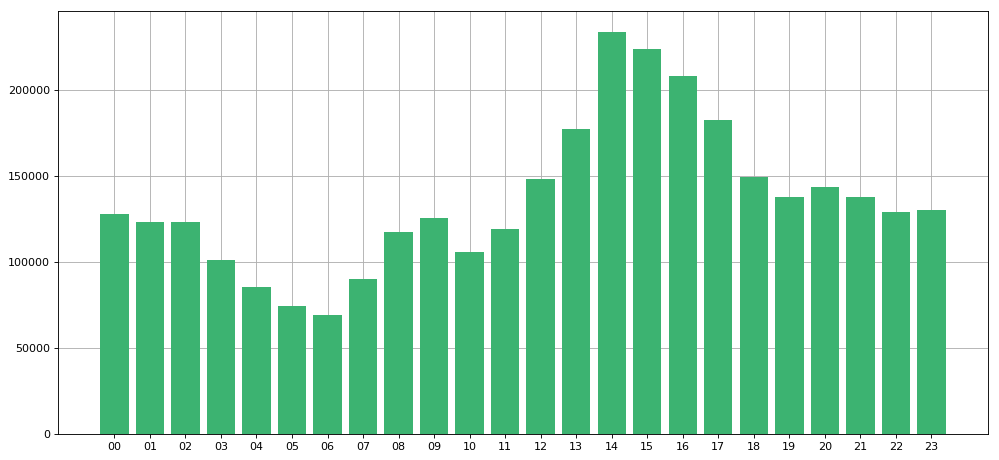

In [36]:
data2_time_of_day = data2_timesorted["tweet_time"].map(lambda x: str(x)[11:13])
data2_only_days = data2_time_of_day.value_counts().sort_index()

figure(num=None, figsize=(15, 7), dpi=80, facecolor='w', edgecolor='k')
plt.bar(data2_only_days.index, data2_only_days, color = "#3CB371", align="center", zorder=3)
plt.grid(zorder=0)

Here the russians have done a good job in timing the tweets. The tweets follows a good frequency regarding to when people are awake, and the majority coming in the evening(here it is necessary to think of the four different time zones in the US). The amount of tweets in especially midnight and in the early morning is a bit high, compared to actual tweet pattern through the day in the USA (https://blog.bufferapp.com/wp-content/uploads/2015/06/Buffer-social-media-science-study-US-popular-times-to-tweet-639x800.png). Regardless of this, people would probably not question this too much if some of the goals are to mimic excessively tweeting political activists, spammers or internet warriors.

### 2.2.3 Different user and category stats

We had a look at the users that got a foothold on the app and got the most followers. What kind of category has each user?

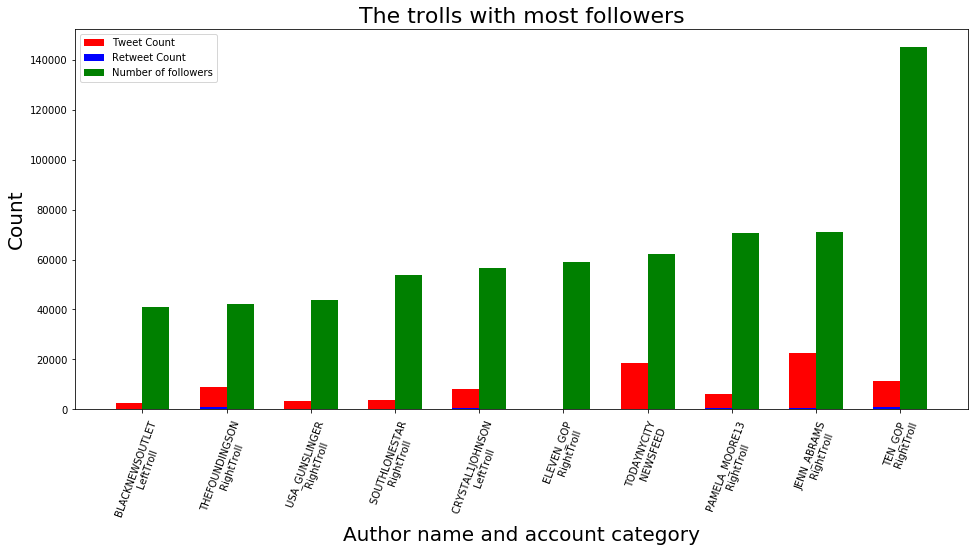

In [38]:
#display(most_pop_authors.tail(10))
fig, ax = plt.subplots(1, 1, figsize=(16,7))
width = 0.32
author_label = ["BLACKNEWSOUTLET \n LeftTroll", "THEFOUNDINGSON \n RightTroll", "USA_GUNSLINGER \n RightTroll", "SOUTHLONESTAR \n RightTroll", "CRYSTAL1JOHNSON \n LeftTroll", "ELEVEN_GOP \n RightTroll", "TODAYNYCITY \n NEWSFEED", "PAMELA_MOORE13 \n RightTroll", "JENN_ABRAMS \n RightTroll", "TEN_GOP \n RightTroll"]

rects1 = ax.bar(np.arange(10), most_pop_authors["tweet_count"].tail(10), width, color='r', label='Tweet Count')
rects1 = ax.bar(np.arange(10), most_pop_authors["retweet_count"].tail(10), width, color='b', label='Retweet Count')
rects2 = ax.bar(np.arange(10) + width, most_pop_authors["peak_followers"].tail(10), width, color='g', label='Number of followers')

#ax2 = ax.twiny()
#ax2.xaxis.set_label_position('bottom')
#ax2.set_xlabel(most_pop_authors.tail(10)["account_category"].tolist(), rotation=0)
#ax2.spines['bottom'].set_position(('outward', 70))
#ax2.set_xlim(ax.get_xlim())
#plt.tight_layout()

ax.set_xticklabels(author_label, rotation=70)
ax.set_xticks(np.arange(10) + width/2)
ax.legend()
name_axises("The trolls with most followers", "Author name and account category", "Count")

We can see that many of the accounts had a huge amount of followers. In this scale it is fully possible to be viewed as a serious tweeter. The author CRYSTAL1JOHNSON for example is a LeftTroll that was frequently retweeted, for example also by Twitter's own creator, Jack Dorsey (http://uk.businessinsider.com/twitter-ceo-jack-dorsey-retweets-russian-trolls-2018-6?r=US&IR=T). Also, Donald Trump personally thanked TEN_GOP for a supporting tweet (https://twitter.com/realDonaldTrump/status/910331061409902592). This proves that the trolls can have serious influence on social media. We can also see that many of the top 10 most followed users are RightTroll, which means that this category easily has been passed on as trustworthy.

We can also see that one could get a lot of popularity regardless of being the most frequent tweeter. Popularity on Twitter is often gained by being retweeted by other popular accounts, like in the example abovementioned. In the case of ELEVEN_GOP so was this the backup account of TEN_GOP, which explains the amount of followers though having just 101 tweets.

The most popular authors does not retweet often, as we barely can see the blue retweet count in any of the top 10 authors.

We also want to take a look at the accounts that has tweeted the most. What kind of category has each user?

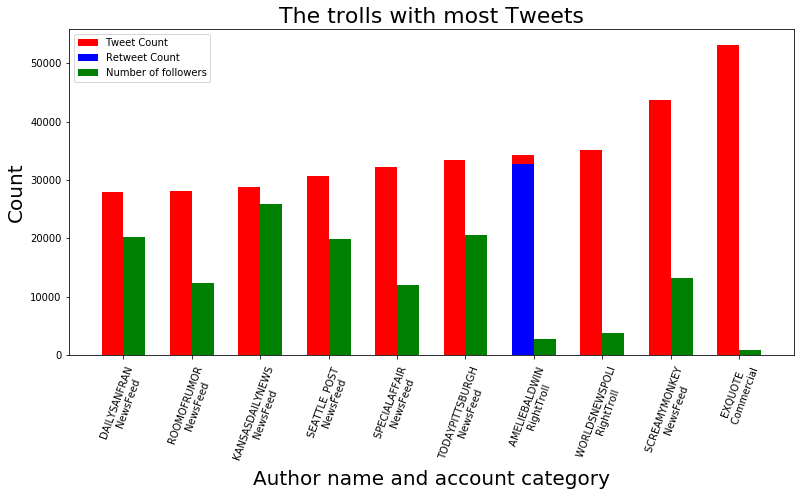

In [40]:
#display(most_active_authors.tail(10))
fig, ax = plt.subplots(1, 1, figsize=(13,6))

width = 0.32
author_label2 = ["DAILYSANFRAN \n NewsFeed", "ROOMOFRUMOR \n NewsFeed", "KANSASDAILYNEWS \n NewsFeed", "SEATTLE_POST \n NewsFeed", "SPECIALAFFAIR \n NewsFeed", "TODAYPITTSBURGH \n NewsFeed", "AMELIEBALDWIN \n RightTroll", "WORLDSNEWSPOLI \n RightTroll", "SCREAMYMONKEY \n NewsFeed", "EXQUOTE \n Commercial"]

rects1 = ax.bar(np.arange(10), most_active_authors["tweet_count"].tail(10), width, color='r', label='Tweet Count')
rects1 = ax.bar(np.arange(10), most_active_authors["retweet_count"].tail(10), width, color='b', label='Retweet Count')
rects2 = ax.bar(np.arange(10) + width, most_active_authors["peak_followers"].tail(10), width, color='g', label='Number of followers')

#ax2 = ax.twiny()
#ax2.xaxis.set_label_position('bottom')
#ax2.set_xlabel(most_active_authors.tail(10)["account_category"].tolist(), rotation=0)
#ax2.spines['bottom'].set_position(('outward', 70))
#ax2.set_xlim(ax.get_xlim())
#plt.tight_layout()

ax.set_xticklabels(author_label2, rotation=70)
ax.set_xticks(np.arange(10) + width/2)
ax.legend()
name_axises("The trolls with most Tweets", "Author name and account category", "Count")


Here we can see that some of the top accounts tweets in enormous scale. Mostly of these are NewsFeed, spreading news disguised as some local institution. In most cases, the news are legitimate and links to real news sources (The tweets in their original form can still be found at (https://russiatweets.com/author). This tactic may be to invoke doubt about whether social media news channels can be seen as trustworhty, but it is hard to say for sure.

It's interesting to notice that almost none of the top 10 retweets at all, except AMELIEBALDWIN which almost exclusively retweets.

Under here, we present a table with the stats of each category. 

In [894]:
authors_count = authors_step["account_category"].value_counts().to_frame()
authors_count.loc['Total']= authors_count.sum()
authors_count["total_tweets"] = data1["account_category"].value_counts()
authors_count = authors_count.fillna(data1.shape[0])
authors_count['average'] = np.where(authors_count['account_category'] < 1, authors_count['account_category'], authors_count['total_tweets']/authors_count['account_category'])
authors_count.average = authors_count.average.astype(int)

trace = go.Table(
    header=dict(values=['Account Category', 'Total number of users', 'Total number of tweets', "Average tweets per user"],
                line = dict(color='#7D7F80'),
                fill = dict(color='#DADA47'),
                align = ['left'] * 5),
    cells=dict(values=[authors_count.index,
                      authors_count["account_category"], authors_count["total_tweets"],authors_count['average'] ],
               line = dict(color='#7D7F80'),
               fill = dict(color='#FFFFAE'),
               align = ['left'] * 5))
layout = dict(width=800, height=500)
data = [trace]
fig = dict(data=data, layout=layout)
py.iplot(fig, filename = 'styled_table')


The NonEnglish category has a low amount of tweets since this table provides the english amount of tweets from these accounts. The average tweet per user is therefore average english tweet per user in just that category.

# 3) Looking into specific research questions
We found out that many of our initial research questions was harder to answer than initially thought, and that is further descripted in part 4 of this notebook. 

Questions we left out:
- Does the trolls advocate for a common political stance in each specific country? If so which leaning do they have? If not, how polarized are the tweets between left leaning and right leaning?

- Which themes does the propaganda mainly revolve around? About which issues should people be particularly careful not to believe everything they read? 
  - They generally are about political events happening in that moment of time. The stance on each case is usely taken by the type the user are, on the right or left side.

Questions answered:
 
- Were the trolls united with a common political leaning in the period after the primaries in the US elections?
 
- Was the original mission of the Russian trolls for the US election to make sure that Clinton was not elected, or to get Trump elected?
 
- Are the trolls organized as a unit? Do they interact with each other (retweets, etc)?

- Is there a way for people without a technical background to determine if a tweet is coming from a Russian troll?

New questions:

- How does the regions influence the different types of meddling?
  - We wanted to have a look at how the different political leanings were in the different regions. Is there any sort of tactic to each place? Mind looking at how the regions are classified in part 1.1.





## 3.1 How does the regions influence the different types of meddling?

We wish to find how the political leanings of the trolls changed by region of operation. We emphasize that our political labels only take english tweets into account. If not there would likely be several extra countries represented.

In [ ]:
#We count our tweets by with account type as column, and countries as rows
categories_country=pd.DataFrame(data1_political.groupby(["region","account_category"]).size()).unstack(level=-1)
#This commented code under was used to check if authors had a distinctive region.
#pd.concat([categories_country, pd.DataFrame(data1_political.drop_duplicates(subset=["external_author_id", "author", "account_category"]).groupby(["region","account_category"]).size()).unstack(level=-1)])
categories_country.columns = categories_country.columns.droplevel()
#We add an extra row with the total amount of each account type
#reorder rows
categories_country=categories_country.filter(['RightTroll','LeftTroll',"NewsFeed"], axis=1)
#an extra column is added to sort out countries with to few political tweets
categories_country['Total'] = categories_country.sum(axis=1)
categories_country = categories_country[categories_country["Total"]>400]
categories_country.loc['Total']= categories_country.sum()
display(categories_country)



We see from our dataframe that the US account for an enormous majority of the political tweets. We also see that there are a lot of political tweets with unknown origin. These two rows nearly account for the entire political dataset, while tweets originating from Canada and UK account for less then 1% combined. Unfortunately, not all of the accounts are assigned with a set, unique region. For example UK had none RightTroll accounts attached to them, which must mean that tweets from the same user suddenly changes region for a short period (The first parameter that gives region is the geolocation, and VPNs may have been used. That can make this analysis skewed.)

In order to take a closer look at the leaning of each region we plot the distribution as a stacked bar chart.

(array([0, 1, 2, 3, 4]), <a list of 5 Text xticklabel objects>)

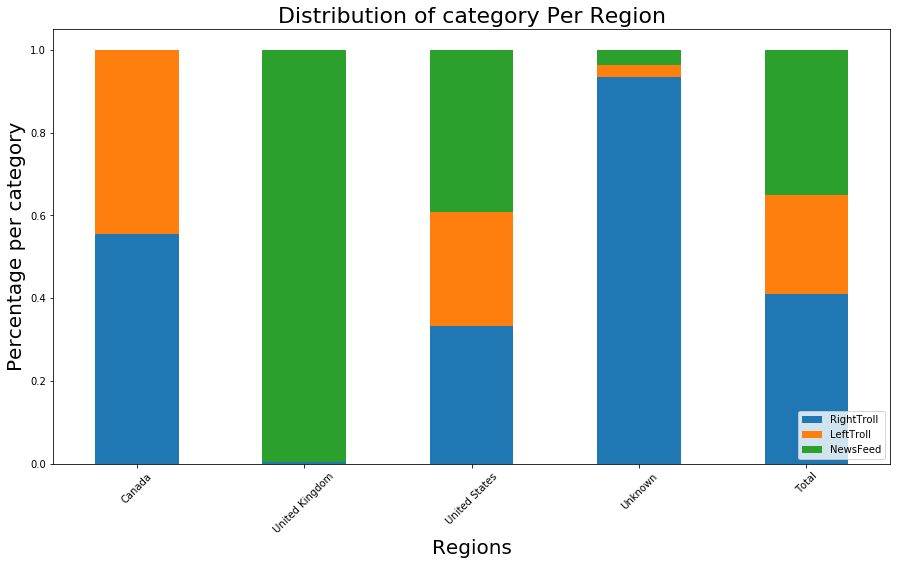

In [44]:
categories_country_distribution = categories_country.loc[:,"RightTroll":"NewsFeed"].div(categories_country["Total"], axis=0)
categories_country_distribution.plot.bar(stacked=True, figsize = (15,8))
name_axises("Distribution of category Per Region","Regions","Percentage per category")
plt.legend(loc=4)
plt.xticks(rotation=45)

We see that the distribution of the tweets differ from country to country. An example of this is that none of the Canadian tweets are about news, while nearly all of those of the UK are labeled as NewsFeed. From the analysis of Linvill and Warren on fivethirtyeight.com, the distributors of this dataset, they said that most of the news was actual news, with some exceptions. Some of the news feed articles were fake, and some of them linked to pro-Russia articles. 

Furthermore we see that tweets from the USA are way more evenly spread out among the categories than the other represented countries, although it is clear that the majority of tweets are labeled as "NewsFeed" and that the right leaning trolls outnumber the left trolls. Strangely nearly all of the tweets with an unknown origin are right leaning trolls. We find it strange that these tweets do not follow a distribution similar to the overall distribution of the entire set. A reason could be that these accounts find it particularly important not to be geolocated and have taken measures for this. This same reasoning could be used for the NewsFeed accounts, since many of them is named after real cities, an should have a geographic connection.

## 3.2 Did the troll activity change in regards to the american primaries?

This was one of our inital research questions. How did the activity change throughout timeline of the political landscape in the US. We are going to look at two different time periods: Before Clinton and Trump was elected as each of the two parties candidates, and after.

**Before primaries:**

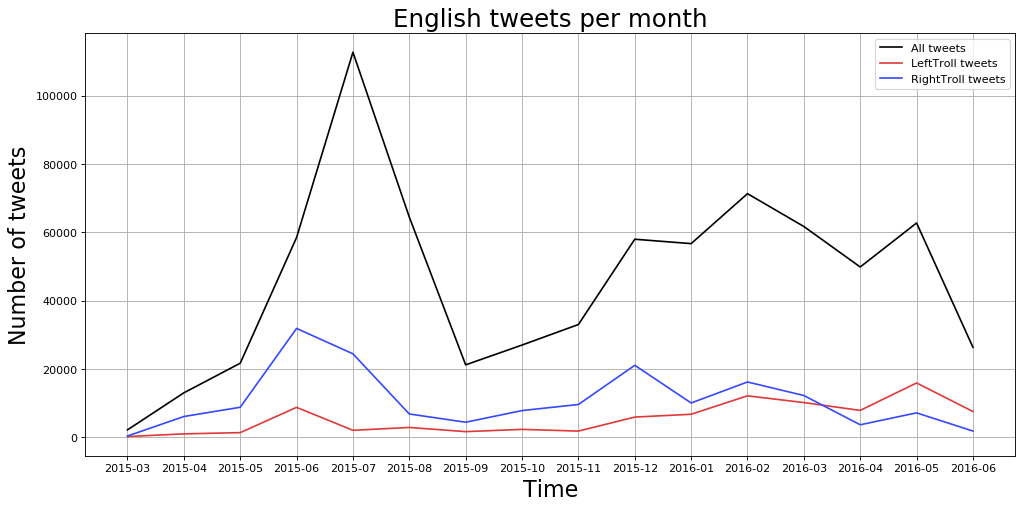

In [45]:
figure(num=None, figsize=(15, 7), dpi=80, facecolor='w', edgecolor='k')
plt.plot(before_primaries_time1.sort_index(), color = "#000000", zorder=3, label = "All tweets")
plt.plot(bp_left_count1.sort_index(), color = "#DE3A3A",zorder=3, label="LeftTroll tweets" )
plt.plot(bp_right_count1.sort_index(), color = "#3549FD",zorder=3, label = "RightTroll tweets")
plt.grid(zorder=0)
plt.legend()
name_axises("English tweets per month", "Time", "Number of tweets")

#figure(num=None, figsize=(15, 9), dpi=80, facecolor='w', edgecolor='k')
#plt.bar(before_primaries_time1.index, before_primaries_time1, color = "#000000", zorder=3, label = "All tweets")
#plt.bar(bp_left_count1.index, bp_left_count1, color = "#DE3A3A", zorder=3, label="LeftTroll tweets")
#plt.bar(bp_right_count1.index, bp_right_count1, color = "#3549FD", zorder=3, label = "RightTroll tweets")
#plt.grid(zorder=0)
#plt.legend()
#name_axises("Tweets per month", "Time", "Number of tweets")

Things really started when the first people startet announcing their candidacy. In the beginning, after the first announced candidacy, it is almost an exponential growth of tweets. We can also see that it is a lot of tweets that are not political categorized as well. 

**After primaries**

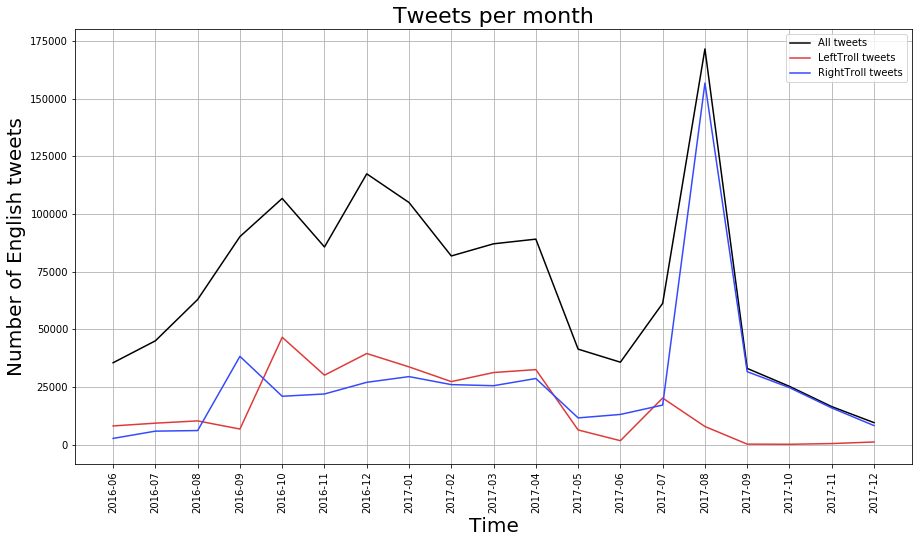

In [46]:
fig, ax = plt.subplots(1,1,figsize=(15,8))
plt.plot(after_primaries_time1.sort_index(), color = "#000000",zorder=3,  label = "All tweets")
plt.plot(ap_left_count1.sort_index(), color = "#DE3A3A",zorder=3, label="LeftTroll tweets" )
plt.plot(ap_right_count1.sort_index(), color = "#3549FD",zorder=3,label = "RightTroll tweets" )
plt.grid(zorder=0)
ax.set_xticklabels(after_primaries_time1.sort_index().index, rotation=90)
plt.legend()
name_axises("Tweets per month", "Time", "Number of English tweets")

#fig1, ax1 = plt.subplots(1,1, figsize=(15,8))
#plt.bar(after_primaries_time1.index, after_primaries_time1, color = "#000000", zorder=3)
#plt.bar(ap_left_count1.index, ap_left_count1, color = "#DE3A3A", zorder =3)
#plt.bar(ap_right_count1.index, ap_right_count1, color = "#3549FD", zorder =3)
#plt.grid(zorder=0)
#ax1.set_xticklabels(after_primaries_time1.sort_index().index, rotation=90)
#name_axises("Tweets per month", "Time", "Number of English tweets")

Regarding to our research question we can say that the announcements of the primaries was were the Right and Left trolls really started to appear. At this point, the IRA decided to turn their heads towards american politics. It is actually surprisingsly quiet the same month as the primaries, so the results of the primaries may not have been a significant moment as earlier thought. 

The month of the election and the period around this had a stable tweet amount from both sides. Interestingly enough, we can see that leftist tweets actually dominated until May 2017, and after that it has almost only been the activity of right trolls. Before the primaries the right tweeters were the dominating ones, but we had a whole year where there were more left than right tweets. It is hard to tell exactly why, it may have been a strategy to go harder for dividing the left side up to the election, but why left trolls kept on dominating after the election is hard to say. This may tell us that the specific strategies for the goals of Russia is not as easy to detract from the different troll categories, as it seems like it is a kind of mixed one in this phase.

From August 2017 the datasets consists almost exclusively of RightTroll tweets. From this point it seems like that they decided to shift their focus from a mixture of trolls to only fronting the right side.


### 3.3 Are the trolls having similar tweet patterns and bot-like behaviour?

**In order to answer this question we wish to inspect the content of the tweets to see if the trolls write the same tweets. If this is the case it is very likely that they operate as a unit with specific messages to share. This analysis will provide a foundation for further work in our next analysises as well, giving more insight to the questions regarding if they interact with each other and whether is it possible for people to recognize trolls.**

In [37]:
#Remove tweets with exact same content by the same author
without_same_tweet_author2 = data2.filter(["userid","tweet_text","post_type"]).drop_duplicates()
#Count occurences of each tweet content and sort
content_df2 = without_same_tweet_author2.groupby("tweet_text").size().to_frame()
content_df2.columns=["count"]
content_df2 = content_df2.sort_values("count",ascending=False)
#display findings
display(content_df2.head(10))

,count
tweet_text,
RT @df6ab937d93fac60a3a274d6f346bd3f872eb9dec3101afea32b20007b01ef14: #ICantBreathe without Putin http://t.co/nKIlsz0PqW,241
RT @2a43e23eca4448ffca04ed734fc93ed2039e1d73da5c30ecded8bf36214f5425: Holy Christ! This #DeadHorse is scary… http://t.co/XYMeONzJ30,131
Forget about your house of cards,129
"We are what we think. All that we are arises with our thoughts. With our thoughts, we make the world.",121
"No, I'm not saying I'm sorry",117
And I'll do mine,114
Tell me would you kill to save for a life?,114
I don't belong here,113
No alarms and no surprises please,108


By the initial look the two top counts are retweets. We are curious to see if these tweets are mainly original tweets, or if the case is that they mainly retweet the same tweets since they are also identical. 

In [38]:
#Count of the same content based with post type on columns
with_post_type2 = without_same_tweet_author2.groupby(["tweet_text","post_type"]).size().to_frame().unstack(level=-1)
with_post_type2.columns = with_post_type2.columns.droplevel()
#sort by common retweet and display, then do same for original tweets
with_post_type_rt = with_post_type2.sort_values("RETWEET",ascending=False)[["RETWEET"]]
display(with_post_type_rt.head(10))
with_post_type_orig = with_post_type2.sort_values("ORIGINAL",ascending=False)[["ORIGINAL"]]
display(with_post_type_orig.head(10))

post_type,RETWEET
tweet_text,
RT @df6ab937d93fac60a3a274d6f346bd3f872eb9dec3101afea32b20007b01ef14: #ICantBreathe without Putin http://t.co/nKIlsz0PqW,241.0
RT @2a43e23eca4448ffca04ed734fc93ed2039e1d73da5c30ecded8bf36214f5425: Holy Christ! This #DeadHorse is scary… http://t.co/XYMeONzJ30,131.0
RT @marthensasser: #ColumbianChemicals The information about plant explosion had been received from the witnesses http://t.co/bYSJd0Rc7c,105.0
"RT @KevinGreen89: A terrible plant explosion happened at the #ColumbianChemicals Co in Centerville, LA",104.0
"RT @KevinGreen89: #ColumbianChemicals The explosion occured at the chemical plant located in Centerville, LA",100.0
"RT @marthensasser: The video showed the explosion at #ColumbianChemicals Co, St. Mary Parish, Louisiana appeared on the internet",99.0
"RT @marthensasser: The explosion occured at the chemical plant located in Centerville, LA #ColumbianChemicals http://t.co/azsU0ef6iz",96.0
"RT @ed8c4f95706defeec5db342e967fa202eeecab31fdef5bddb50bd38f3cba24a4: Chemical plant exploded in Centerville, Louisiana #ColumbianChemicals http://t.co/aTWhO7tINl",76.0
RT @4dc4f9360437c779e3a5b85b96681af17d4748f121cb3ec9b3b055e3988ad264: Freaking creepy #DeadHorse http://t.co/9kiqfne3ds,69.0


post_type,ORIGINAL
tweet_text,
Forget about your house of cards,129.0
"We are what we think. All that we are arises with our thoughts. With our thoughts, we make the world.",121.0
"No, I'm not saying I'm sorry",117.0
Tell me would you kill to save for a life?,114.0
And I'll do mine,114.0
I don't belong here,113.0
No alarms and no surprises please,108.0
One day maybe we'll meet again,108.0
Maybe the children of a lesser God,107.0


We see from the two sorted frames that most of the tweets that occur many times are retweets. This makes sense as a retweet is by design the same tweet. The most common original tweets are a bit special. These are small lines that in themselves does not give a clear message, but rather a poetic line or saying. These are very general statings but it is weird having so many users tweeting the same content with a significant length, which implies the usage of bots.


In order to take a look at weether they run bots, we remove the links in the tweets and sort. If the amount of tweets with the same content increase drastically this is an indication that they run bots that re-use the description of the links. We have to remove the top entry which is blank since these are tweets that are links and nothing else.

In [39]:
#we strip data on https to remove links and only keep start of tweet
stripped_data2 = without_same_tweet_author2
stripped_data2["tweet_text"]=stripped_data2["tweet_text"].apply(lambda s: str(s).split("http")[0].strip())
#we sort data by contents of the remaining part of the tweet. We then remove the top entry as this is an empty string since the whole tweet was a link.
stripped_data2 = stripped_data2.groupby(["tweet_text"]).size().sort_values(ascending=False).to_frame().iloc[1:]
stripped_data2.columns=["count"]
#we display the resulting tweets sorted by tweet count
display(stripped_data2.head(5))

,count
tweet_text,
🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸 President Trump will make America great again! #AmericaFirst #MakeAmericaGreatAgain #MAGA 🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸,1223
RT @CtrlSec: Targeted #ISIS accounts,959
🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸 President Trump will make America great again! #AmericaFirst #MakeAmericaGreatAgain #MAGA 🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸,401
#ObamaGate #ObamaWiretap IS true so 💥#ARRESTObama💥 💥#ARRESTObama💥 💥#ARRESTObama💥 💥#ARRESTObama💥 💥#ARRESTObama💥 💥#ARRESTObama💥 💥💥💥💥💥💥💥💥💥 🚂🚂🚂🚂,373
😎🌞☀️JAMES COMEY IS FIRED☀️🌞😎 @FBI #DrainTheSwamp #AmericaFirst #MAGA,299


Here we can see that many of the tweets after removing links are retweets, which is natural given that they contain the same content. There are also original tweets here, mostly of them leaning on being right trolls. The length of the original tweets and also the exact number of the emojis also suggests heavily usage of bots.

We plot the comparision of the dataset before and after the removal of links. The text in the figure is derived from the three lines in the cell under, using different data frames.

In [115]:
print(content_df2[content_df2["count"]!=1].sum())
print(content_df2[content_df2["count"]!=1].shape[0])
print(content_df2[content_df2["count"]==1].sum())

count    919419
dtype: int64
184652
count    2228566
dtype: int64


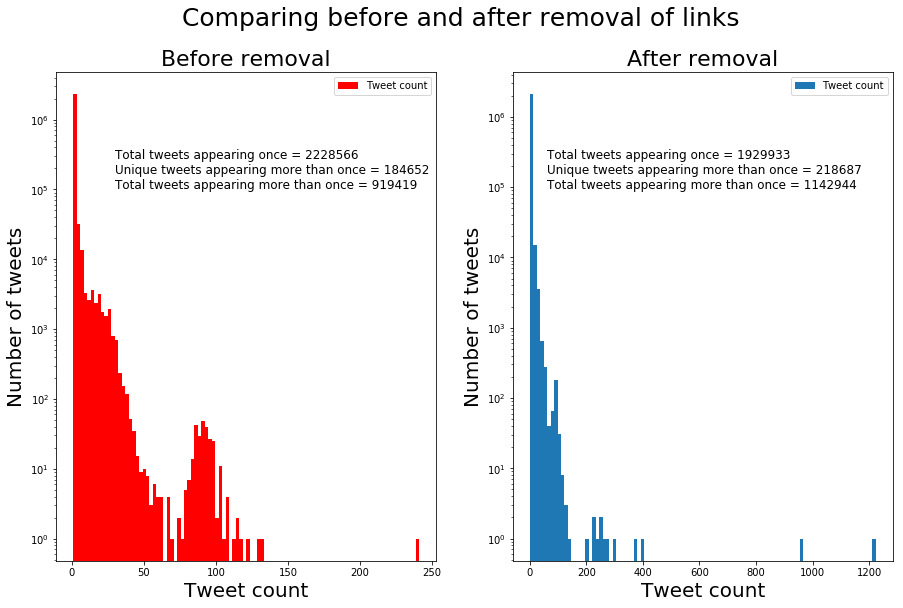

In [40]:
fig, axs = plt.subplots(1, 2, figsize =(15,9))

axs[0].hist(content_df2["count"], bins=100, log =True, label="Tweet count", color='r')
plt.figtext(.18, .7, "Total tweets appearing once = 2228566 \nUnique tweets appearing more than once = 184652\nTotal tweets appearing more than once = 919419 ", fontsize='large')
axs[0].set_title('Before removal', size=22)
axs[0].set_xlabel("Tweet count", size=20)
axs[0].set_ylabel("Number of tweets", size=20)
axs[0].legend(loc=1)

fig.suptitle("Comparing before and after removal of links", fontsize=25)
axs[1].hist(stripped_data2["count"], bins=100, log =True , label = "Tweet count")
plt.figtext(.58, .7, "Total tweets appearing once = 1929933 \nUnique tweets appearing more than once = 218687\nTotal tweets appearing more than once = 1142944 ", fontsize='large')
name_axises("After removal","Tweet count","Number of tweets")
axs[1].legend(loc=1)

We see that there are clearly several tweets that have been tweeted several times by several people. However according to the distribution these are in an overwhelming minority compared to tweets only posted a small number of times. This indicates that they are organized to some extent, as they do have a lot of tweets with the same content independent of each other, although this is in only a small extent compared to the overall tweeting.


Note that outliers makes the two x-axises different.

A lot of the identical tweets are retweets so we want to filter out the original content to look at the amount of tweets that was duplicated in it's original form.

,count
tweet_text,
🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸 President Trump will make America great again! #AmericaFirst #MakeAmericaGreatAgain #MAGA 🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸,1223
🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸 President Trump will make America great again! #AmericaFirst #MakeAmericaGreatAgain #MAGA 🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸,401
#ObamaGate #ObamaWiretap IS true so 💥#ARRESTObama💥 💥#ARRESTObama💥 💥#ARRESTObama💥 💥#ARRESTObama💥 💥#ARRESTObama💥 💥#ARRESTObama💥 💥💥💥💥💥💥💥💥💥 🚂🚂🚂🚂,373
😎🌞☀️JAMES COMEY IS FIRED☀️🌞😎 @FBI #DrainTheSwamp #AmericaFirst #MAGA,299
🚨🚨🚨🚨🚨 @NBC must take @AlecBaldwin out of @NBCSNL! #AbusiveAlec @ABFAlecBaldwin,267
Comment here on,246
🚨WE ARE AT #WAR!‼️🚨 🔥#MAGA🔥 🔥#Vault7🔥 🔥#CivilWarII🔥 🔥#WakeUpUSA🔥 🔥#ShadowGovernment🔥 🔥#ObamaGate🔥 🔥#ARRESTObama🔥 🔥#TheMessyTruth🔥 🔥#Wiretap🔥,229
@AffableCreation 🚨 😃 SO COOL! 😃 🚨,225
@AffableCreation @AmicableUser @808MCL @HawaiianCraftTV 🚨😃☀️GOOD MORNING!☀️😃🚨 🚨😃☀️IT'S SUNDAY MORNING!☀️😃🚨,197


Text(0.51, 0.72, 'Total tweets appearing once = 1381247 \nUnique tweets appearing more than once = 81732\nTotal tweets appearing more than once = 622255 ')

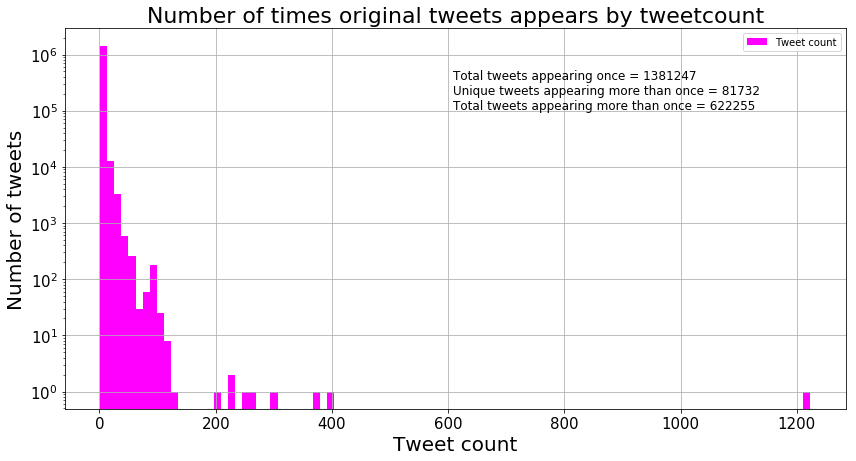

In [41]:
without_rts = without_same_tweet_author2[without_same_tweet_author2["post_type"] != "RETWEET"]
without_rts["tweet_text"]= without_rts["tweet_text"].apply(lambda s: str(s).split("http")[0].strip())
without_rts = without_rts.groupby(["tweet_text"]).size().sort_values(ascending=False).to_frame().iloc[1:]
without_rts.columns=["count"]
display(without_rts.head(10))

without_rts.hist(bins=100, figsize=(14,7), xlabelsize=15, ylabelsize=15, log =True, label="Tweet count", color="fuchsia")
name_axises("Number of times original tweets appears by tweetcount","Tweet count","Number of tweets")
plt.legend(loc=1)
plt.figtext(.51, .72, "Total tweets appearing once = 1381247 \nUnique tweets appearing more than once = 81732\nTotal tweets appearing more than once = 622255 ", fontsize='large')

We can see that a lot of the original tweets really is not that original. In number of unique tweets the amount of unique tweets that is tweeted more than once does not seem to surprising, but when you look at the number these unique tweets has been tweeted this clearly indicates massive use of bots. Under follows a table that shows the stats of original content.

In [42]:
original_content = without_rts[without_rts["count"] == 1].shape[0]
reused_content = without_rts[without_rts["count"] != 1].sum().tolist()[0]
total_content = without_rts.sum().tolist()[0]

In [829]:
trace = go.Table(
    header=dict(values=['Original content appearing once', 'Original content appearing multiple times in the data set', "Total number of original content"],
                line = dict(color='#7D7F80'),
                fill = dict(color='#DADA47'),
                align = ['left'] * 5),
    cells=dict(values=[(original_content, "68,9 %"),
                      (reused_content, "31,1 %"), (total_content, "100 %")],
               line = dict(color='#7D7F80'),
               fill = dict(color='#FFFFAE'),
               align = ['left'] * 5))
layout = dict(width=800, height=500)
data = [trace]
fig = dict(data=data, layout=layout)
py.iplot(fig, filename = 'styled_table')


In [60]:
over_75 = without_rts[without_rts["count"] > 74].drop(axis=0, index = ["Comment here on", "I added a video to a @YouTube playlist", "awesome"])
over_75_textlist = over_75.index.tolist()
user_text = data2[["userid", "tweet_text", "post_type"]]
user_text = user_text[user_text["post_type"] != "RETWEET"]
user_text["tweet_text"]= user_text["tweet_text"].apply(lambda s: str(s).split("http")[0].strip())
bot_dataset = user_text.loc[user_text['tweet_text'].isin(over_75_textlist)]
bot_users = bot_dataset[["userid"]].drop_duplicates()
#percentage of bots is taken by dividing number of bot-like pattern on total users.
print("Number of users that have bot-like tweet pattern: ", bot_users.shape[0], "\nTotal users: ", data2[["userid"]].drop_duplicates().shape[0], "\nPercentage of users with bot-like tweet pattern: ", 28.41)


Number of users that have bot-like tweet pattern:  926 
Total users:  3259 
Percentage of users with bot-like tweet pattern:  28.41


Over 28% of the users have tweeted exact tweets that appears 75 times or more in the dataset. Some of them may have slipped in by randomingly tweeting the same as 75 other people, but this foremost concludes that they are a part of a network that have the same tweets. As seen in the list a few cells up here, those tweets are of a significant length and order such that tweeting the same content repeatedly seems unlikely. One can detect these users as bots on Twitter in general by searching for the same content in the search menu in Twitter. If the content appears numerous times, there is a high propability for it being a bot. More on this in the following analysis. 

The percentage here is taken from all users that tweet in english. In future analysis regarding the question whether someone can detect Twitter trolls we will also limit the tweets to being "impacting" tweets which will elevate this number. More on this later.

## 3.4 Are the trolls interacting with each other - continued.


We want to see whether the trolls communicate, and if they do: get an idea of how. 
In order to do this, we use the newer dataset as this has info about what tweets, and therefore, which users a tweet is responding to. We start by loading some of the dataframes to parquet and then read.

The definition of an interaction is as follows:
- Retweeting.
- Quoting as a quote tweet.
- Replying to a tweet.
- Retweeting a quote tweet. This counts as two interactions, as both the user that quote tweets and the user quoted gets notifications in Twitter. The opposite is not possible in Twitter.
- Replying with a quote tweet. This also counts as two, since you are directly interacting with two users at the same time.

In the new dataset you can interact with two people in one tweet, but never more. In reality, there is possible two interact with almost hundreds in one tweet, since you for example could retweet a reply that replies to a conversation involving numerous persons only limited by Twitter 280 character restriction. Retweeting a reply only counts as one retweet in the set and replying someone also just counts as one reply even though people that are in a thread recieve notifications. 

The full extent of interactions is therefore not possible to extract of this dataset, but this limiting still gives sort of an advantage for analysing interactions per tweet, since the two possibilities are so rare that it almost gives us an one-to-one ratio of tweets and interactions.

### 3.4.1 Preliminary work.

In this phase we will be doing spark queries to create frames for the analysis in this part. 

**In order to get a sense of the extent of the communication we want to get a sense of the overall activity of the user, and therefore make a dataframe containing information of how many tweets a user has made, as well as how many times their tweets have been retweeted, replied to or quoted by other users. We also add the language of the user.**

**We will continue adding columns in order to get a complete sense of how the communication is conducted**

In [8]:
n_stats = stats.select("userid","reply_count","quote_count","retweet_count","tweetid")
summed = n_stats.groupBy("userid").agg(count("tweetid"), sum("reply_count"),sum("quote_count"),sum("retweet_count"))
summed = summed.join(users, "userid").select("userid",col("account_language").alias("language"),"count(tweetid)",
                                             "sum(retweet_count)", "sum(reply_count)","sum(quote_count)")
summed.sort(desc("sum(retweet_count)")).show(5)

+------------------+--------+--------------+------------------+----------------+----------------+
|            userid|language|count(tweetid)|sum(retweet_count)|sum(reply_count)|sum(quote_count)|
+------------------+--------+--------------+------------------+----------------+----------------+
|        4224729994|      en|         10794|           6000296|          632061|          520919|
|        4437233895|      en|          7915|           3776481|           77201|          273749|
|        4272870988|      en|          6203|           2223854|          244440|          207688|
|842368501528559616|      en|          2288|           1217081|          115617|           53697|
|905514350684844036|      en|          3067|           1171652|           27778|           94465|
+------------------+--------+--------------+------------------+----------------+----------------+
only showing top 5 rows



**We continue by adding columns for how many times a user has retweeted someone, this could be any twitter user. We also add a column stating how many times a individual twitter user has been retweeted by the trolls.**

In [9]:
#make dataframe with retweets, containing userful information
retweets = (stats.where(col("retweet_tweetid").isNotNull())).select("retweet_tweetid","retweet_userid","userid",
                                                                    col("tweetid").alias("retweeting_tweetid"))

#Find how many times a user has retweeted and add this to our user-dataframe
retweets_by_user = retweets.groupBy("userid").agg(count("*"))\
                .select(col("userid").alias("usrid"),col("count(1)").alias("retweets"))
aggregated_with_retweets = summed.join(retweets_by_user,retweets_by_user.usrid == summed.userid,"left_outer").drop("usrid")


#Make dataframe of tweets where trolls retweets other trolls
u=users.select(col("userid").alias("usrid"))
retweets_within = users.select("userid").join(retweets, "userid")
retweets_within = u.join(retweets_within, retweets_within.retweet_userid==u.usrid )\
                .select("retweet_tweetid","retweeting_tweetid","retweet_userid","userid")
    
#Make df containing number of times a user has been retweeted by trolls, and add column to user-df
retweeted_by_troll = retweets_within.groupBy("retweet_userid").agg(count("*"))\
                .select("retweet_userid",col("count(1)").alias("retweeted_by_trolls"))
aggregated_with_retweets = aggregated_with_retweets.join(retweeted_by_troll,retweeted_by_troll.retweet_userid 
                                            == aggregated_with_retweets.userid,"left_outer").drop("retweet_userid")

#Make df containing number of times a troll has retweeted other trolls, and add column to user-df
retweets_of_troll = retweets_within.groupBy("userid").agg(count("*"))\
                .select("userid",col("count(1)").alias("retweets_of_troll"))
aggregated_with_retweets = aggregated_with_retweets.join(retweets_of_troll,"userid","left_outer")


**We now wish to add similar columns to see how the trolls speak to each other in the literal sense; by replying to each other. We first add total number of replies by user, then add how many times they have been replied to, as well as how many times they themselves have replied to other trolls.**

In [10]:
#filter out everything that is not replies
replies = stats.where(col("in_reply_to_tweetid").isNotNull())\
        .select("in_reply_to_tweetid","in_reply_to_userid","userid",col("tweetid").alias("replyid"))

    
#make df with number of times each user has replied to someone, not only trolls, add this to main df.
replies_by_user = replies.groupBy("userid").agg(count("*"))\
                .select("userid",col("count(1)").alias("number_of_replies"))
aggregated_with_replies = aggregated_with_retweets.join(
                replies_by_user,"userid","left_outer")

#replies from one troll to another
replies_within = u.join(replies, u.usrid == replies.in_reply_to_userid)
replies_within = replies_within.join(users,"userid").select("userid","in_reply_to_userid","replyid")
    
#add a column with how many times each user have been replied to by a troll
replies_to_user = replies_within.groupBy("in_reply_to_userid").agg(count("*"))\
                .select(col("in_reply_to_userid").alias("userid"),col("count(1)").alias("replies_by_trolls"))
aggregated_with_replies = aggregated_with_replies.join(replies_to_user,"userid","left_outer")


#make column with count of times a troll has retweeted another troll
replies_by_user = replies_within.groupBy("userid").agg(count("*"))\
                .select("userid",col("count(1)").alias("replies_to_trolls"))
aggregated_with_replies = aggregated_with_replies.join(replies_by_user,"userid","left_outer")


**Now that we have information of how they retweet and reply to each other we additionally want to add information on how the trolls interact using quote tweets. In the same matter as before, we add how many times each troll have quoted someone else, how many times they quoted another troll, as well as how many times they have been quoted by other trolls.**

In [11]:
#Filter out everything that is not quotes
quotes = stats.where(col("quoted_tweet_tweetid").isNotNull())\
        .select("quoted_tweet_tweetid",col("userid").alias("quoting_userid"),col("tweetid").alias("quoteid"))

#Add column to main dataframe with how many times a troll has quoted someone
quotes_by_user = quotes.groupBy("quoting_userid").agg(count("*"))\
                .select("quoting_userid",col("count(1)").alias("quote_tweets"))
aggregated_with_quotes = aggregated_with_replies.join(quotes_by_user,quotes_by_user.quoting_userid 
                                        == aggregated_with_replies.userid,"left_outer").drop("quoting_userid")

#Creating df where troll quotes other trolls
quotes_within = stats.drop("quoted_tweet_tweetid").join(quotes, stats.tweetid == quotes.quoted_tweet_tweetid)\
                .select("quoting_userid","quoted_tweet_tweetid","quoteid",col("userid").alias("quoted_userid"))

#Add column to main dataframe with how many times a troll has been quoted by another troll
quotes_to_user = quotes_within.groupBy("quoted_userid").agg(count("*"))\
                .select("quoted_userid",col("count(1)").alias("quoted_by_trolls"))
aggregated_with_quotes = aggregated_with_quotes.join(quotes_to_user,quotes_to_user.quoted_userid 
                                                     == aggregated_with_quotes.userid,"left_outer")\
                                                    .drop("quoted_userid")

    
#Add column showing how many times each troll has quoted another troll
quotes_by_user = quotes_within.groupBy("quoting_userid").agg(count("*"))\
                .select("quoting_userid",col("count(1)").alias("quoted_a_troll"))
aggregated_with_quotes = aggregated_with_quotes.join(quotes_by_user,quotes_by_user.quoting_userid == 
                                                     aggregated_with_quotes.userid,"left_outer").drop("quoting_userid")


In [12]:
user_interactions = aggregated_with_quotes.na.fill(0)


In [13]:
interactions_df = user_interactions.toPandas().set_index("userid")
interactions_df.head(5)

,language,count(tweetid),sum(retweet_count),sum(reply_count),sum(quote_count),retweets,retweeted_by_trolls,retweets_of_troll,number_of_replies,replies_by_trolls,replies_to_trolls,quote_tweets,quoted_by_trolls,quoted_a_troll
userid,,,,,,,,,,,,,,
1cf2f6f6e0e87b7856deda07f1f4ba15dba59fe610283cb1379c1c4c97a00e3a,en,10,0,0,0,0,0,0,0,0,0,0,0,0
202c8708b3ed415e943eade0a8e5bfb0ce7ceaf93fcc462d3bb271f73e487f2b,ru,9292,764,7,0,6111,678,3226,53,2,52,0,0,0
36f2768e6fcac2041cd5604315cab62bc02c808f1ddb3492bb7b265db4875a59,en,3932,256,62,17,2263,53,322,18,1,0,44,1,3
3daea00c3d9d2530c840254c6fa6fc3c14837681269a8739a23f463b844e1c16,ru,1865,51,89,3,80,0,0,228,0,0,3,0,0
4a899897e0eeacbb0df34904b6fa75a5560c1b305051f4b86ae6652bae2738ca,en,10,0,0,0,10,0,0,0,0,0,0,0,0


In [247]:
interactions_df.groupby("language").sum()

,count(tweetid),sum(retweet_count),sum(reply_count),sum(quote_count),retweets,retweeted_by_trolls,retweets_of_troll,number_of_replies,replies_by_trolls,replies_to_trolls,quote_tweets,quoted_by_trolls,quoted_a_troll
language,,,,,,,,,,,,,
ar,3452,344,193,0,590,2,65,1617,8,3,162,1,0
de,102657,70081,15051,8736,12550,1316,1271,2035,359,359,1144,54,54
en,4608003,23066172,1773081,1667743,1711236,368552,305737,133147,17323,19525,157600,14064,13962
en-gb,21494,68453,3575,1561,1849,8016,599,23,456,2,1,3,0
es,285044,103021,15310,9207,860,263,256,1,0,0,10702,34,114
fr,1409,72,21,1,265,0,0,46,0,0,39,0,0
id,22966,155,68,6,0,0,0,0,0,0,1,0,0
it,13105,0,4,0,13098,0,0,0,0,0,106,0,0
ru,3953675,7940616,730729,104105,1592734,522156,592377,129339,26370,24627,18112,685,711


Here we can see the number of tweets in each language plus the same stats as in the data frame above. An interesting take from here is that the russian language trolls has much more interactions with other trolls than the english ones, almost doubling the count.

### Total internal reactions and different ratios.

Now we are going to add other statistics regarding how many times the users interacts with trolls and the ratios of how often they do this. The added columns are:
- Total reactions from trolls: How many times trolls have interacted to their tweets.
- Total reactions to trolls: How many times the user has interacted to other trolls tweets.
- Total interactions: How many times the user has interacted at all.
- Total times interacted with: How many times the user has totally been interacted with by all Twitter users.
- Ratio reactions to trolls: The ratio of how often a user has interacted to another troll divided by total amount of tweets this user has.
- Ratio interaction from trolls: The ratio of how many interactions to this user that are from other trolls divided by total interactions to this user.
- Ratio interaction with trolls: The ratio of how often the user is interacting to other users divided by total interactions.

In [830]:
interactions_df["Total_reactions_from_trolls"] = interactions_df["retweeted_by_trolls"]+interactions_df["replies_by_trolls"]+interactions_df["quoted_by_trolls"]
interactions_df["Total_reactions_to_trolls"] = interactions_df["retweets_of_troll"]+interactions_df["replies_to_trolls"]+interactions_df["quoted_a_troll"]
interactions_df["Total_interactions"]=interactions_df["retweets"]+interactions_df["number_of_replies"]+interactions_df["quote_tweets"]
interactions_df["Total_times_interacted_with"]=(interactions_df["sum(retweet_count)"]+interactions_df["sum(reply_count)"]+interactions_df["sum(quote_count)"])
interactions_df["Ratio_reactions_to_trolls"] = interactions_df["Total_reactions_to_trolls"]/interactions_df["count(tweetid)"]
interactions_df["Ratio_interaction_from_trolls"] = interactions_df["Total_reactions_from_trolls"]/interactions_df["Total_times_interacted_with"]
interactions_df["Ratio_interaction_with_trolls"] = interactions_df["Total_reactions_to_trolls"]/interactions_df["Total_interactions"]
interactions_df = interactions_df.sort_values("Ratio_reactions_from_trolls",ascending=False)

interactions_df.head(10)

,language,count(tweetid),sum(retweet_count),sum(reply_count),sum(quote_count),retweets,retweeted_by_trolls,retweets_of_troll,number_of_replies,replies_by_trolls,...,quoted_a_troll,Total_reactions_from_trolls,Total_reactions_to_trolls,Total_interactions,Total_times_interacted_with,Ratio_reactions_to_trolls,Ratio_reactions_from_trolls,Ratio_interaction_with_trolls,Interaction_per_tweet_ratio,Ratio_interaction_from_trolls
userid,,,,,,,,,,,,,,,,,,,,,
2d5c740d091be162a2085e2981ed0d2765e07aca9743fd83a43023ff450cb360,en,56,5,2,0,19,0,0,9,0,...,0,47,0,46,7,0.000000,6.714286,0.000000,0.821429,6.714286
7e22164b92faa9cc2a929254a7f61d2a31f03632592dd86af6f098c16c674dfa,en,1,0,1,0,0,0,0,0,3,...,0,3,0,0,1,0.000000,3.000000,NaN,0.000000,3.000000
12c1da578346af4a43fba0a2d7abda7267b76dd001733a3f677896392413b5a3,ru,189,4,0,0,137,9,123,0,0,...,0,9,123,137,4,0.650794,2.250000,0.897810,0.724868,2.250000
98e02a027fe0ce3ff8f520bf80bc221c825e1e4c4ac31d38d3e379ea088c5653,en,33,1,0,0,24,1,0,0,1,...,0,2,0,24,1,0.000000,2.000000,0.000000,0.727273,2.000000
31335878feb9b2d23fcfb8d3f9a936922aa9df4ba0faf5091394161fbf9539c8,en,8,4,0,0,3,4,0,0,3,...,0,7,0,3,4,0.000000,1.750000,0.000000,0.375000,1.750000
1820d713ea1dcbb15a826cf0c7aa8ed2d5fd8180f4fb273f0cc05ec72813e825,en,16,5,0,0,5,5,0,0,3,...,0,8,0,5,5,0.000000,1.600000,0.000000,0.312500,1.600000
555f324dd0c61be9b745fdd77ff3ef66f8af26c5952dd93d0da0af004fb59fd4,en,270,1,1,0,135,0,4,0,3,...,0,3,4,135,2,0.014815,1.500000,0.029630,0.500000,1.500000
74ceb7c6a46a5beb0910a670a50859fd8af49d024f4bdbd2aab0cc78b7c2c9be,ru,6648,4,0,0,6602,0,11,0,6,...,0,6,11,6991,4,0.001655,1.500000,0.001573,1.051594,1.500000
f1b17005b47a98b40fee810556971d621dee6860038a237418a5a8db0aa176cb,en,77,4,0,0,36,4,0,0,2,...,0,6,0,36,4,0.000000,1.500000,0.000000,0.467532,1.500000


Here is the final table with all the interaction stats of the users.
PS: The sum columns of retweets, replies and quotes means the number of times the user has been retweeted, replied to or quoted.

If we look at the ratio reactions from trolls we can see that something is wrong, since these numbers should not have been higher than 1. Looking into this we found out that the number of times a user has been interacted with is wrong, since for example the user with a ratio of 6.7 is listed with being quoted zero times, but looking at the other trolls we saw that other trolls actually had quoted this user. We looked extensively into this and found out that this the counts are wrong in the dataset. Therefore we will be extremely careful in our analysis of this and not do much with it.

The next cell was created since one in our project group had problems with spark, in addition to creating a new column with interactions per tweet, which is the number of interactions per total number of tweets.

In [836]:
#interactions_df.to_parquet('interactions.parquet.gzip', compression='gzip')
interactions_df = pd.read_parquet('interactions.parquet.gzip')
#Replace infinity with nan, since this occurs by the division of zeros.
interactions_df = interactions_df.replace([np.inf, -np.inf], np.nan)
#Create the new colum
interactions_df["Interaction_per_tweet_ratio"] = interactions_df["Total_interactions"]/interactions_df["count(tweetid)"]
interactions_df = interactions_df.sort_values("Interaction_per_tweet_ratio", ascending=False).fillna(0)
interactions_df[["Interaction_per_tweet_ratio"]].head(10)

,Interaction_per_tweet_ratio
userid,
43f5fc4c8ee88ab0981b52c83d8e22766908dd68527ef3ee7701321edcdb30ab,1.923077
15901f2969231684e5b4f04a820b64180d94f285d22d4a802103ac8462b861b9,1.337500
91543ad6161c511dd3670a32c39d6ea1a4178dd50fb0abf1f97f156aaa521357,1.250000
e07abd509e7fb342e064d5ab9b41a1c1db7debe2d6388af93beb734f4340b5b5,1.250000
d57b13eb823583e6b8e958dc650b118708539a7c816fec20c9e07d96b350b397,1.225806
96d4f0c1f4b4ed7638342a48c66c401263da4b151fdffcb98d7b775c996c3fb6,1.160652
8d313bc4410c3158379fb24df70f09dc2f5c96cef6aa527df856b61d1ffdd89e,1.156450
f78a269be68e66b4a8c9bb5adbe49f617b6b3845134de4b9d8afe7a350bfb2cd,1.155975
8a010562843fd054add7bcd50610886626731674a53c6c1e40232111ff960a27,1.142857


Here we can see the phenomenom described in the introduction to this part, that some users have had a number of their tweets as quotes and replies simoultaneously. Except the extremes listed over, this will still be a close one-to-one relationship since it occurs seldom.

### 3.4.2 Visualisations and results.

We want to split up the number of times each user has tweeted into different buckets. We create buckets that we put the users in, each bucket being a range of total number of tweets.
First we create a frame with all the users put into each bucket. 

In [837]:
#Make a function that changes categorical index to string index in plotting
def cat_to_string(df):
    df.index = df.index.astype(str)
    return df

#Make a function that does all the aggregation for us, as well as changing index to compatible form.
def group_tweetcount(df, range_list):
    grouped = df[["count(tweetid)"]].groupby(pd.cut(df["count(tweetid)"], range_list)).count()
    return cat_to_string(grouped)
    

We chose the buckets by looking into the distribution of the tweet counts and also keeping a natural increase of the number of them. It will still contain some bias, since users around the limit could easily had fallen into one or another. The range stops at 160000 since this covers the highest amount of tweets from a single user.

In [839]:
interactions_en = interactions_df[interactions_df["language"]=="en"]
ien_tweetcount = interactions_en["count(tweetid)"].sort_values().to_frame() 
ranges = [0,10,50,100, 250, 500, 1000, 2500, 5000, 10000, 160000]
ientc_distribution =  group_tweetcount(ien_tweetcount, ranges)
display(ientc_distribution)

#Create a number of the total users to use in further statistics regarding percentage.
total_users = ientc_distribution["count(tweetid)"].sum()

,count(tweetid)
count(tweetid),
"(0, 10]",263
"(10, 50]",180
"(50, 100]",154
"(100, 250]",181
"(250, 500]",518
"(500, 1000]",238
"(1000, 2500]",234
"(2500, 5000]",255
"(5000, 10000]",189


In the next cell we create a count for the users that have interacted with other Twitter users, and also the users that have had interactions from other users in any form. Interactions here means the same as defined earlier.

In [840]:
interacting_users = interactions_en[interactions_en["Total_interactions"] > 0][["count(tweetid)"]]
iu_distribution = group_tweetcount(interacting_users, ranges)

interacted_users = interactions_en[interactions_en["Total_times_interacted_with"] > 0][["count(tweetid)"]]
interacted_users_distribution = group_tweetcount(interacted_users, ranges)

In the last cell we create frames that includes users that have interacted to, or have been interacted with by other trolls in the dataset.

In [841]:
interacted_to = interactions_en[interactions_en["Total_reactions_to_trolls"] > 0][["count(tweetid)"]]
iw_distribution = group_tweetcount(interacted_to, ranges)

interacted_from = interactions_en[interactions_en["Total_reactions_from_trolls"] > 0][["count(tweetid)"]]
if_distribution = group_tweetcount(interacted_from, ranges)

Then we plot the distribution of users in each bucket:

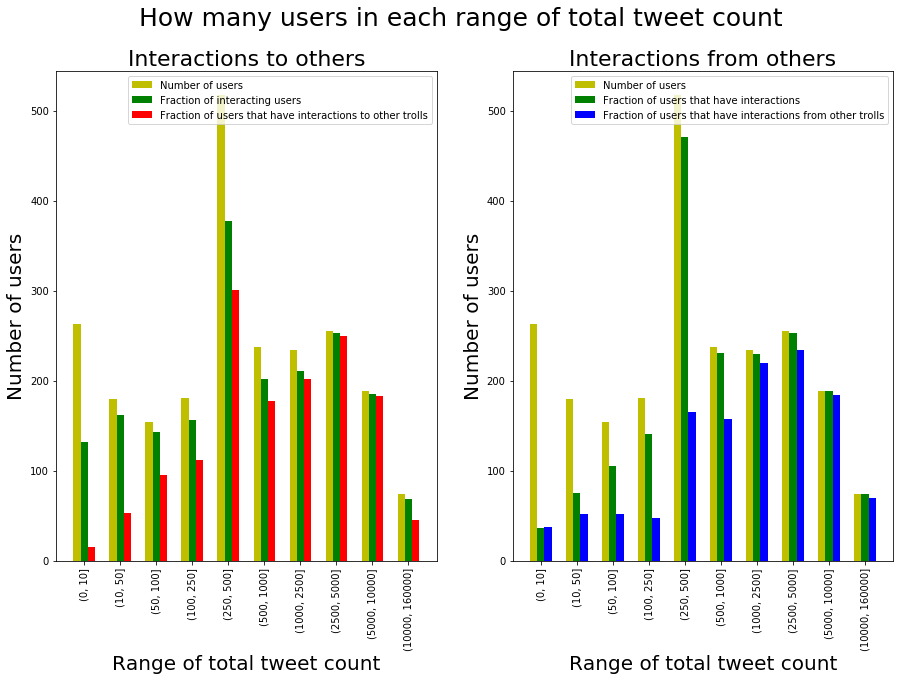

In [426]:
fig, ax = plt.subplots(1, 2, figsize =(15,9))
fig.suptitle("How many users in each range of total tweet count", fontsize=25)

#plot first chart
ax[0].set_title('Interactions to others', size=22)
ax[0].set_xlabel("Range of total tweet count", size=20)
ax[0].set_ylabel("Number of users", size=20)
#set width for each bar.
width = 0.2
#Set labels and ticks.
ax[0].set_xticks(np.arange(10) + width)
ax[0].set_xticklabels(ientc_distribution.index, rotation=90)
#plot the bars.
ax[0].bar(np.arange(10), ientc_distribution["count(tweetid)"], width, label = "Number of users", color = "y")
ax[0].bar(np.arange(10) + width, iu_distribution["count(tweetid)"], width, label = "Fraction of interacting users", color = "green")
ax[0].bar(np.arange(10) + width*2, iw_distribution["count(tweetid)"], width,  label = "Fraction of users that have interactions to other trolls", color = "r")
ax[0].legend()

#plot second chart:
ax[1].bar(np.arange(10), ientc_distribution["count(tweetid)"], width, label = "Number of users", color = "y")
ax[1].bar(np.arange(10) + width, interacted_users_distribution["count(tweetid)"], width, label = "Fraction of users that have interactions", color = "green")
ax[1].bar(np.arange(10) + width*2, if_distribution["count(tweetid)"], width, label = "Fraction of users that have interactions from other trolls", color = "b")
ax[1].set_xticks(np.arange(10) + width)
ax[1].set_xticklabels(ientc_distribution.index, rotation=90)
name_axises("Interactions from others","Range of total tweet count" , "Number of users")
plt.legend()


By looking at the distribution we can see that most users tweet under 500 times, but the difference is not is not very huge between users that have tweeted less than 500 times and users that have tweeted over 500 times.

We can also see that the number of users that have interactions from others are skewed in this plot. The green bars could and should probably be a little bit higher, especially remarked in the bucket (0,10]. The blue bars still account for what it is meant to be.

There are a fraction of users that have tweeted in such small numbers, so the impact of them is very small. Here we can see that the more tweets the users have the more likely it is that interactions with other trolls increases as well, which is natural. 

The most interesting aspect is probably the mastodonts that have tweeted over 10000 times. These users have a lot higher fraction of those being interacted with by other users than interacting themselves, even though the large amount of tweets. This differs significantly from the user with between 1000 and 10000 tweets, and you should think that the the higher tweet count the more even the three bars would be, as it seems that this is the natural way the relationship between the three bars evolve.

We want to cut out all the users that have tweeted less than or 10 times to avoid the users that have had such short-spanned Twitter activity. These users submit only a minimal part of the total tweets in the total dataset, so to have a look at further statistics in our analysis we remove them since they probably do not make any impact on Twitter.

We are now going to plot a cumulative distribution that shows in which scale the trolls interact with each other.

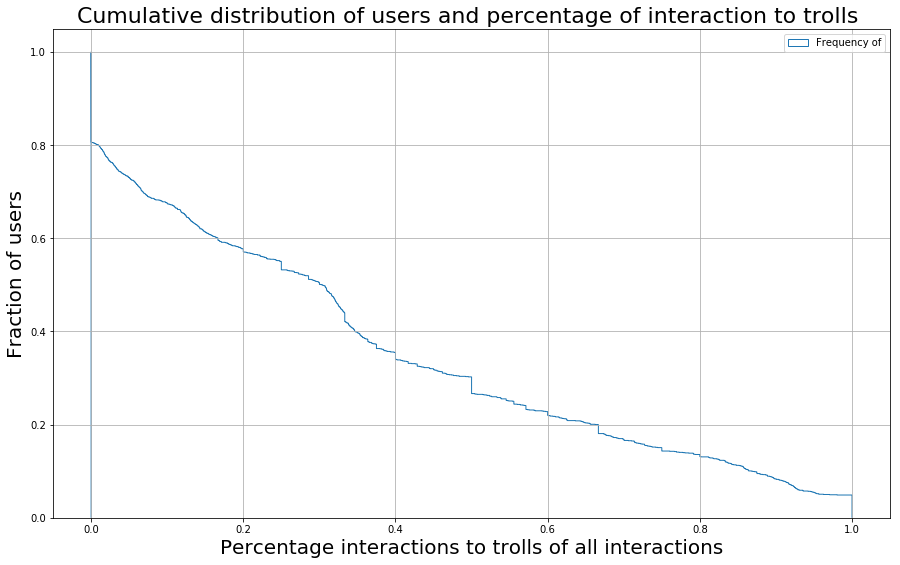

In [632]:
enough_tweets = interactions_en[interactions_en["count(tweetid)"]>10]
fig, ax = plt.subplots(1, 1, figsize =(15,9))
ax.hist(enough_tweets["Ratio_interaction_with_trolls"], bins=5000000, histtype='step', density=True, cumulative=-1, label='Frequency of')
name_axises('Cumulative distribution of users and percentage of interaction to trolls ', 'Percentage interactions to trolls of all interactions', 'Fraction of users')
ax.grid()
ax.legend()


To interpret this visualization:
- This mean that almost 20% of the trolls have never interacted to trolls.
- 50% of the users have more than 30% of theire interactions directed to trolls, and 50% has less than 30%.
- Around 30% of trolls have more than 50% of their interactions directed to trolls.
- Around 5% of the users only interact with trolls.

#### Top interacting users and top most interacted with users.
Before writing the conclusion on if the trolls interact with each other, here are some plots of the extremes in the dataset.

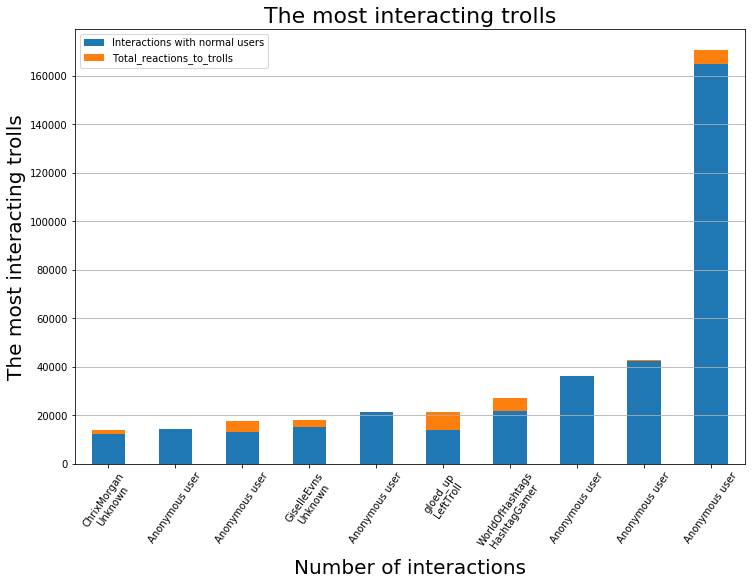

In [875]:
#Create dataframes
most_interacting = interactions_en.sort_values("Total_interactions",ascending=True).tail(10)
most_interacting["Interactions with normal users"]= most_interacting["Total_interactions"]-most_interacting["Total_reactions_to_trolls"]
#plot figure 
fig = most_interacting[["Interactions with normal users", "Total_reactions_to_trolls"]].plot.bar(stacked=True, figsize = (12,8), label = "j")
plt.grid(axis='y')
xlabelauthors = ["Anonymous user", "Anonymous user", "Anonymous user", "WorldOfHashtags\nHashtagGamer", "gloed_up\nLeftTroll", "Anonymous user", "GiselleEvns\nUnknown", "Anonymous user", "Anonymous user", "ChrixMorgan\nUnknown"]
xlabelauthors = list(reversed(xlabelauthors))
fig.set_xticklabels(xlabelauthors, rotation=55, size=10)
plt.legend()
name_axises("The most interacting trolls", "Number of interactions", "The most interacting trolls")

Most of these users were hashed in the dataset so we don't know there names. One user stands out with over 160000 interactions (this does not mean 160000 unique users reached). This is the user that also had close up to 160000 tweets, meaning that this user is a giant of a interacter. Interestingly he is doing it mostly to others. 

Some of the users also have a significant number of interactions going towards trolls.

We are also going to show the top 10 users that have had the most interactions from other users. As earlier mentioned, this number is not entirely correct, but comparing the highest numbers to each other it is still possible to get a sense of how much these users have been interacted with by Twitter users. The label total reactions from trolls is still correct.

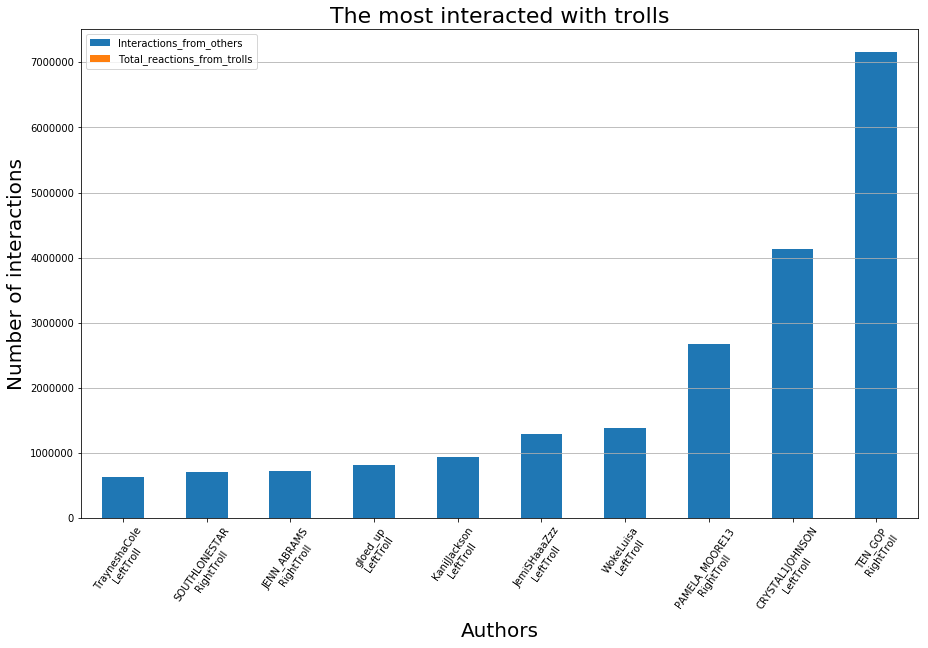

In [878]:
#Create dataframes
most_interacted_with = interactions_en.sort_values("Total_times_interacted_with",ascending=True).tail(10)
most_interacted_with["Interactions_from_others"]= most_interacted_with["Total_times_interacted_with"]-most_interacted_with["Total_reactions_from_trolls"]
#plot table
fig = most_interacted_with[["Interactions_from_others","Total_reactions_from_trolls"]].plot.bar(stacked=True, figsize=(15,9), label="")
plt.grid(axis='y')
xlabelauthors = ["TEN_GOP\nRightTroll", "CRYSTAL1JOHNSON\nLeftTroll", "PAMELA_MOORE13\nRightTroll", "WokeLuisa\nLeftTroll", "JemiSHaaaZzz\nLeftTroll", "KaniJJackson\nLeftTroll", "gloed_up\nLeftTroll", "JENN_ABRAMS\nRightTroll", "SOUTHLONESTAR\nRightTroll", "TrayneshaCole\nLeftTroll"]
xlabelauthors = list(reversed(xlabelauthors))
fig.set_xticklabels(xlabelauthors, rotation=55)
plt.legend()
name_axises("The most interacted with trolls",  "Authors","Number of interactions")


It is clear that the users that have been interacted with the most have a so small fraction of troll interactions that it is almost invisible in most cases. This is mostly due to reaching out to so many people that the trolls interacting with these users are basically outnumbered. It may also be that at some point, if the users get popular enough, IRA trolls stops interacting with theses users to mitigate suspicion towards the users, as they can live on their own.

It's also interesting to see that all of these users are trolls with a political leaning, meaning that these users are the ones that have the biggest audience.

### 3.5 Categorizing the users in how they interact and if they have bot-like behaviour.

We are now going to look at the users that was suspected as bots in the analysis from part 3.3 and see how big fraction of those that are in each category, for both interacting users and all users. We will try to use these categories to say something about how a person can detect these users.

The first category we are going to create is the impactless users. As we have seen in analysis 3.4, the plot kind of says that almost none of the trolls that have under 10 tweets have been interacted with users that do not have bot-like tweet pattern (Keep in mind the problems with this column that was mentioned). 

In [642]:
print("Number of non-impacting users:", ientc_distribution.loc["(0, 10]"].tolist()[0])
print("Percentage of non-impacting users:", (ientc_distribution.loc["(0, 10]"].tolist()[0]/total_users)*100)

Number of non-impacting users: 263
Percentage of non-impacting users: 11.504811898512687


Since these users are almost invisible to most of normal Twitter users and only half of them have ever interacted as well, we remove them for the main categorization of users. Most people will never even see those trolls, and users that never get more than ten tweets will in general been questioned as being a significant Twitter user at all.

Therefore the next analysises will contain users that have a minimum of capability of impacting the general discussion, since they are or has been active at all, with that definition only being reaching a number of over 10 tweets.

In [648]:
total_impacting_users = ientc_dist_over_ten.sum().tolist()[0]
total_impacting_users

2023

We apply the same thing to some of the already created tables, removing the users with less than ten tweets.

In [734]:
iu_distribution_over_ten = iu_distribution.drop(index="(0, 10]")

For a lot of this analysis we will create data frames for the distribution of users in many categories. This is mainly for our visualization, and every frame will be visualized at some point. We will not show each data frame to avoid the notebook being too long.

In [848]:
#remove likely bots that have under 10 tweets
new_ranges= [10, 50,100, 250, 500, 1000,2500, 5000, 10000, 160000]
#Create a distribution of bot-like users
bot_users_full = interactions_en[interactions_en.index.isin(bot_users["userid"].tolist())]
bot_distribution = group_tweetcount(bot_users_full, new_ranges)
#Create a distribution of at all interacting likely bots.
interacting_bots = bot_users_full[bot_users_full["Total_interactions"] > 0][bot_users_full["count(tweetid)"] > 10]
ib_distribution = group_tweetcount(interacting_bots, new_ranges)

#removing trolls that have under 10 tweets
ientc_dist_over_ten = ientc_distribution.drop(index="(0, 10]")
print("New percentage of likely bots:", bot_distribution.sum().tolist()[0]/ientc_dist_over_ten.sum().tolist()[0])


New percentage of likely bots: 0.453781512605042


We can now see that the percentage of likely bots has increased from 28,4% to 45,4% since the analysis in 3.3

In the following cell we will be collecting these users and how the users perform in buckets of follower numbers.
We will create buckets that have specific follower ranges. From general statistics on Twitter, this is the distribution for normal Twitter users: 
https://sysomos.com/wp-content/files/twitter-statistics-followers-table.gif
In this dataset things do not follow these pattern, as we are going to see in the following cells. The ranges is distributed to get a even distribution of users, and still keep a natural increase in followers. 

Note: We originally had 10000 followers and more as a level of being very popular users, but since there were only seven users between 7500 and 10000, and 200 between 1000 and 7500 we decided to set 7500 followers or more as very popular users.

In [851]:
def group_followers(df):
    #Create a suitable range for distribution of followers. The highest number of followers is around 250000.
    follower_range = [0, 25, 50, 100, 200, 500, 1000, 7500, 260000]
    grouped = df[["follower_count"]].groupby(pd.cut(df["follower_count"], follower_range)).count()
    return cat_to_string(grouped)

In [740]:
user_followers = new_user[new_user["account_language"] == "en"][["userid", "follower_count"]]
#Create a distribution for the users that are impacting
impacting_users = interactions_en[interactions_en["count(tweetid)"] > 10]

#Create distribution for the followers of the users
user_followers = user_followers[user_followers["userid"].isin(impacting_users.index) == True]
user_followers_dist = group_followers(user_followers)
#Create distribution for the followers of the bots.
bot_followers = user_followers[user_followers["userid"].isin(impacting_bots.index) == True]
bot_followers_dist = group_followers(bot_followers)


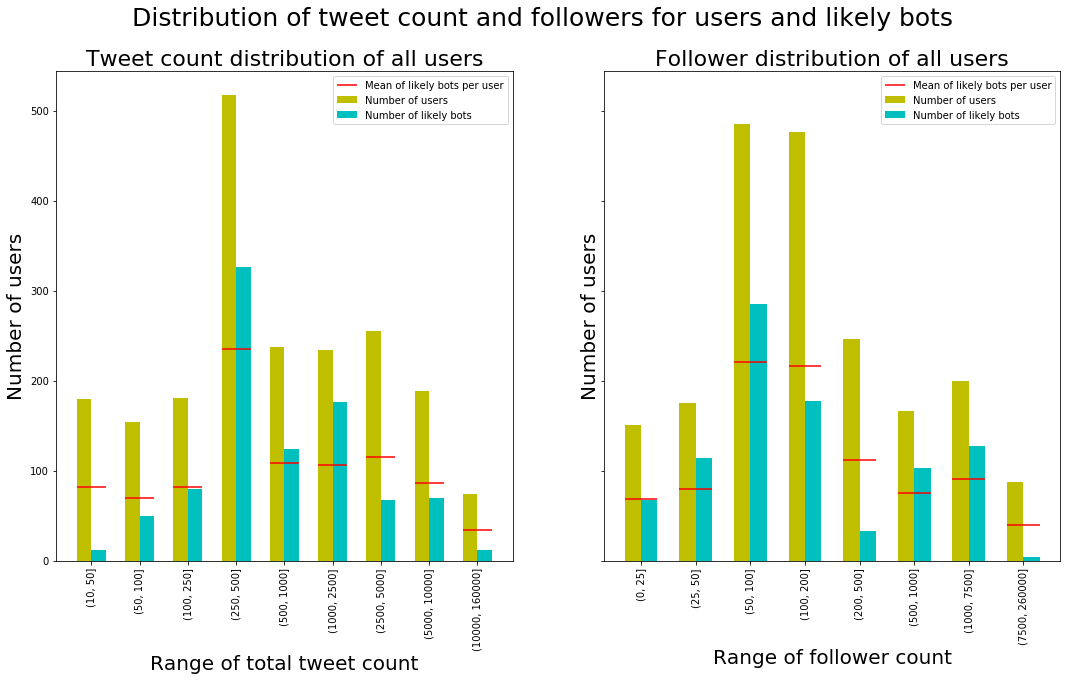

In [874]:
fig, ax = plt.subplots(1, 2, figsize =(18,9), sharey=True)
fig.suptitle("Distribution of tweet count and followers for users and likely bots", fontsize=25)

width = 0.3
#Plot first plot
ax[0].bar(np.arange(9), ientc_dist_over_ten["count(tweetid)"], width, label = "Number of users", color = "y")
ax[0].bar(np.arange(9) + width, bot_distribution["count(tweetid)"], width, label = "Number of likely bots", color = "c")
barstart = np.array([r.get_x() for r in ax[0].patches])
barend = barstart + np.array([r.get_width()*2 for r in ax[0].patches])

#the percentage multiplier is taken from the cell earlier in the same analysis.
ax[0].set_xticklabels(ientc_dist_over_ten.index, rotation=90)
ax[0].set_xticks(np.arange(9) + width/2)
ax[0].set_title('Tweet count distribution of all users', size=22)
ax[0].set_xlabel("Range of total tweet count", size=20)
ax[0].set_ylabel("Number of users", size=20)
ax[0].hlines((ientc_dist_over_ten["count(tweetid)"]*0.454).tolist(), barstart ,barend,color='r', linestyle='-', label = "Mean of likely bots per user")
ax[0].legend()
#Plot second plot
ax[1].bar(np.arange(8), user_followers_dist["follower_count"], width, label = "Number of users", color = "y")
ax[1].bar(np.arange(8) + width, bot_followers_dist["follower_count"], width, label = "Number of likely bots", color = "c")
ax[1].set_xticklabels(user_followers_dist.index, rotation=90)
ax[1].set_xticks(np.arange(8) + width/2)
name_axises("Follower distribution of all users","Range of follower count" , "Number of users")
ax[1].hlines((user_followers_dist["follower_count"]*0.454).tolist(), barstart ,barend,color='r', linestyle='-', label = "Mean of likely bots per user")
ax[1].legend()

Here we can see the distribution of likely bots. When trolls come up in a certain number, it becomes more likely for them being bots. There may be subranges that have higher amount of bots than others as well, since our ranges are randomly picked to have a more distributed visualization. Most of the results here is just around its own standard deviation, especially with the followers. That the bucket (200, 500] followers has so low amount of likely bots must for example be a coincidence.

We could maybe also have removed all users with under 50 tweets, since there are also very few of these bots that fall under our likelihood, and their impact is as well limited.

The most interesting parts are on the right side of both subplots. Even though having the largest amount of tweets and followers, they don't tweet the same duplicated content in spite of having a much higher sample size. 

#### Category 1: Non-interacting users.

As we can see that some of the columns drops in size, this indicates that some of the users have not been interacting at all, as we already know. This leads to creating the first category, non-interacting users, which is split up into two sub-categories: Non-interacting users with regular pattern, and non-interacting users with bot-like pattern.

In [706]:
#Distribution of none interacting users
none_interacting_users = interactions_en[interactions_en["Interaction_per_tweet_ratio"] == 0][interactions_en["count(tweetid)"] > 10]
niu_distribution = group_tweetcount(none_interacting_users, new_ranges)
#distribution of none-interacting bots
none_interacting_bots = bot_users_full[bot_users_full["Interaction_per_tweet_ratio"] == 0]
nib_distribution = group_tweetcount(none_interacting_bots, new_ranges)
#follower distribution of non-interactive users
niu_followers = user_followers[user_followers["userid"].isin(none_interacting_users.index) == True]
niu_followers_distribution = group_followers(niu_followers)
#follower distribution of non-interacting bots
nib_followers = user_followers[user_followers["userid"].isin(none_interacting_bots.index) == True]
nib_followers_distribution = group_followers(nib_followers)

#These last operations here will be used for later plotting.
#Distribution of interacting users
interacting_users = interactions_en[interactions_en["Interaction_per_tweet_ratio"] > 0][interactions_en["count(tweetid)"] > 10]
interacting_users_distribution = group_tweetcount(interacting_users, new_ranges)
#distribution of the followers of interacting users
interacting_users_followers = user_followers[user_followers["userid"].isin(interacting_users.index) == True]
interacting_users_followers_distribution = group_followers(interacting_users_followers)
#distribution of interacting bots
interacting_bots = bot_users_full[bot_users_full["Interaction_per_tweet_ratio"] > 0]
interacting_bots_distribution = group_tweetcount(interacting_bots, new_ranges)
#follower distribution of interacting bots
interacting_bots_followers = user_followers[user_followers["userid"].isin(interacting_bots.index) == True]
interacting_bots_followers_distribution = group_followers(interacting_bots_followers)


For each category we now will be creating we will provide at table with statistics of how this category is represented in the dataset in total, since this is not easy to detract from the visualization.

In [747]:
def statistics_table(users, bots):
    df = pd.DataFrame(columns=["Users in this category","Fraction of total users"])
    df["Users in this category"] = np.asarray([users.shape[0], bots.shape[0]])
    df["Fraction of total users"] = np.asarray([float("{0:.3f}".format(users.shape[0]/total_impacting_users)), float("{0:.3f}".format(bots.shape[0]/total_impacting_users))])
    df["Fraction of total likely bots"] = np.asarray([" ", float("{0:.3f}".format(bots.shape[0]/bot_users_full.shape[0]))])
    df["User types"] = np.asarray(['All users', 'Likely bots'])
    df = df.set_index(["User types"])
    return df
non_interacting_frame = statistics_table(none_interacting_users, none_interacting_bots)
display(non_interacting_frame)

,Users in this category,Fraction of total users,Fraction of total likely bots
User types,,,
All users,264,0.130,
Likely bots,168,0.083,0.183


These users account for 13% of the dataset, and 8.3 percentage points of these are likely bots.
Of all likely bots 18,3 % is likely bots from this category.

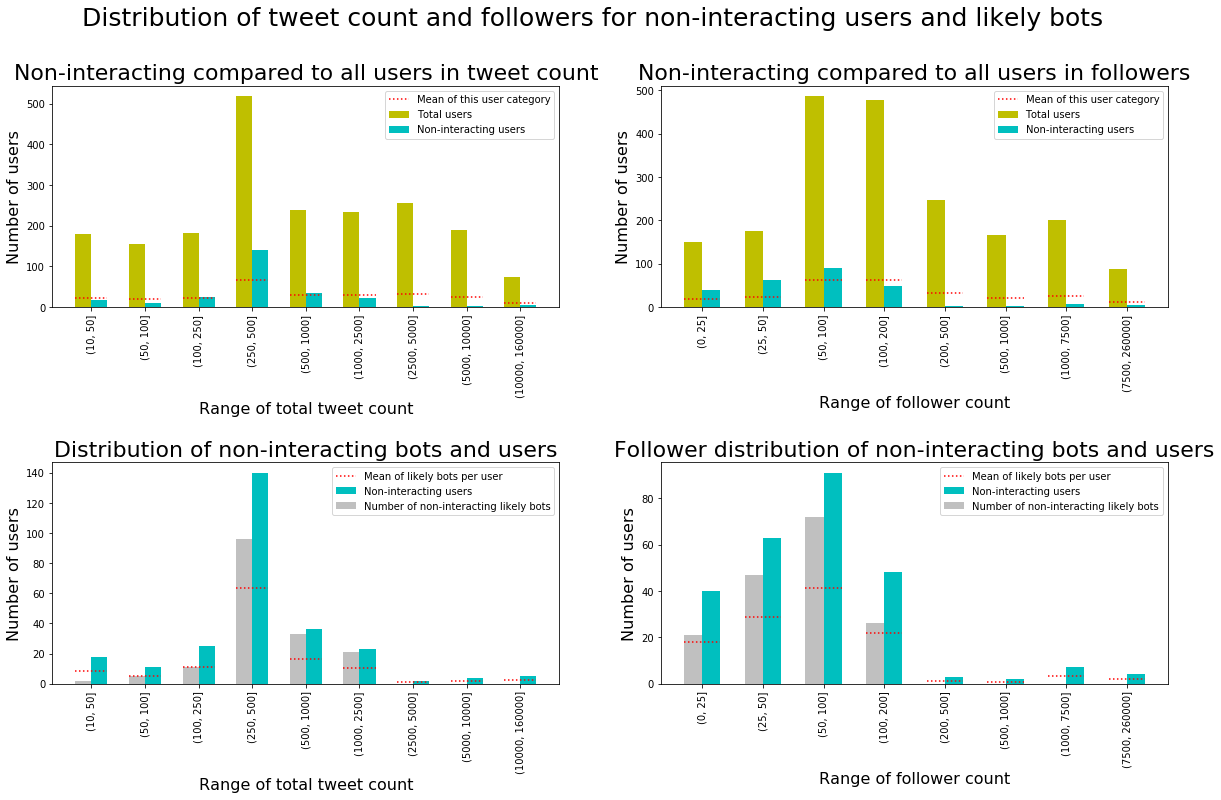

In [853]:
fig, ax = plt.subplots(2, 2, figsize =(20,11))
fig.suptitle("Distribution of tweet count and followers for non-interacting users and likely bots", fontsize=25)
plt.subplots_adjust(hspace=0.7)

width=0.3
ax[0][0].set_title('Non-interacting compared to all users in tweet count', size=22)
ax[0][1].set_title('Non-interacting compared to all users in followers', size=22)
ax[1][0].set_title('Distribution of non-interacting bots and users', size=22)
ax[1][1].set_title('Follower distribution of non-interacting bots and users', size=22)
#plot total users in each subplot.
ax[0][0].bar(np.arange(9), ientc_dist_over_ten["count(tweetid)"], width, label = "Total users", color = "y")
ax[0][1].bar(np.arange(8), user_followers_dist["follower_count"], width, label = "Total users", color = "y")

#the percentage multiplier is taken from earlier in the analysis.
#Here we made a lot of plotting functions for later visualizations.
def plot_basics(users, followers, label, color):        
    for i in [0,1]:
        ax[i][0].set_xlabel("Range of total tweet count", size=16)
        ax[i][1].set_xlabel("Range of follower count", size=16)                
        ax[i][0].set_xticks(np.arange(9) + width/2)
        ax[i][0].set_xticklabels(ientc_dist_over_ten.index, rotation=90)
        ax[i][0].bar(np.arange(9) + width, users["count(tweetid)"], width, label = label, color = color)
        ax[i][1].set_xticks(np.arange(8) + width/2)
        ax[i][1].set_xticklabels(user_followers_dist.index, rotation=90)
        ax[i][1].bar(np.arange(8)+width, followers["follower_count"], width, label = label, color = color)
    #Add line with total mean of bots.
    ax[1][0].hlines((users["count(tweetid)"]*0.454).tolist(), barstart_left ,barend_left,color='r', linestyle='dotted', label = "Mean of likely bots per user")
    ax[1][1].hlines((followers["follower_count"]*0.454).tolist(), barstart_left, barend_left, color='r', linestyle='dotted', label = "Mean of likely bots per user")

#Plot non-interacting users tweetcount and followers
plot_basics(niu_distribution, niu_followers_distribution, "Non-interacting users", "c")
barstart_left = np.array([r.get_x() for r in ax[0][0].patches])
barend_left = barstart_left + np.array([r.get_width()*2 for r in ax[0][0].patches])


def plot_category_mean(percentage):
    ax[0][0].hlines((ientc_dist_over_ten["count(tweetid)"]*percentage).tolist(), barstart_left ,barend_left,color='r', linestyle='dotted', label = "Mean of this user category")
    ax[0][1].hlines((user_followers_dist["follower_count"]*percentage).tolist(), barstart_left, barend_left, color='r', linestyle='dotted', label = "Mean of this user category")       
#number taken from table in cell over.
plot_category_mean(0.1305)

def plot_bots(users, followers, label, color):
    ax[1][0].bar(np.arange(9), users["count(tweetid)"], width, label=label, color=color)
    ax[1][1].bar(np.arange(8), followers["follower_count"], width, label =label, color=color)
#Plot non-interacting bots tweetcount and followers
plot_bots(nib_distribution, nib_followers_distribution, "Number of non-interacting likely bots", "silver")
    
def set_labels():
    for i in [0,1]:
        for j in [0,1]:
            ax[i][j].set_ylabel("Number of users", size=16)
            ax[i][j].legend()
set_labels()


In this category we can see clearer traits for this category. We don't find many users with high tweet count and high amount of followers.
The likely bots can be regocnized with having under 200 followers and under 2500 tweets. The impact of these users are pretty limited, but they still are a significant part of the data set with 8,3%. It seems also that many of these bots have a almost fixed number of tweets, as we can find the most of them in a specific range of tweet count.

In non-interacting users with over 1000 followers we find NewsFeed users like PhiladelphiaOnline, Daily Los Angeles, Newspeak Daily. All users with more than 7500 followers and 10000 tweets is actually NewsFeed users.

#### Category 2: Mainly troll-interacting users

So now we are going to take a deeper look into the users that interact at all: We will remove the users that don't interact from the visualizations, but keep them in the percentage calculations of all users. Now we will look at another category: *Mainly troll interacting users*, which are users that have over 50% of their interactions toward trolls.

In [660]:
#Create tweet distribution of mainly troll-interacting users
troll_interacting_users = interactions_en[interactions_en["Ratio_interaction_with_trolls"] >= 0.5][interactions_en["count(tweetid)"] > 10]
ti_users_distribution = group_tweetcount(troll_interacting_users, new_ranges)
#Tweet distribution of mainly troll-interacting bots
troll_interacting_bots = bot_users_full[bot_users_full["Ratio_interaction_with_trolls"] >= 0.5]
tib_distribution = group_tweetcount(troll_interacting_bots, new_ranges)
#Follower distribution of mainly troll-interacting users
tiu_followers = user_followers[user_followers["userid"].isin(troll_interacting_users.index) == True]
tiu_followers_distribution = group_followers(tiu_followers)
#Follower distribution of mainly troll-interacting bots
tib_followers = user_followers[user_followers["userid"].isin(troll_interacting_bots.index) == True]
tib_followers_distribution = group_followers(tib_followers)

In [748]:
main_troll_interacting_frame = statistics_table(troll_interacting_users, troll_interacting_bots)
#We will add a fraction of interacting users to use in for the visualization of the mean
def add_interactive_frac(df, users, bots):
    df["Fraction of interacting users of each user type"] = np.asarray([float("{0:.3f}".format(users.shape[0]/interacting_users.shape[0])), float("{0:.2f}".format(bots.shape[0]/interacting_bots.shape[0]))])
add_interactive_frac(main_troll_interacting_frame, troll_interacting_users, troll_interacting_bots)
main_troll_interacting_frame

,Users in this category,Fraction of total users,Fraction of total likely bots,Fraction of interacting users of each user type
User types,,,,
All users,532,0.263,,0.302
Likely bots,223,0.110,0.243,0.300


Main troll-interacting users account for 26,3% of the dataset, and 11 percentage points of these are likely bots.
Of all likely bots 24,3 % is likely bots from this category, and 30% of all interacting bots are this category.

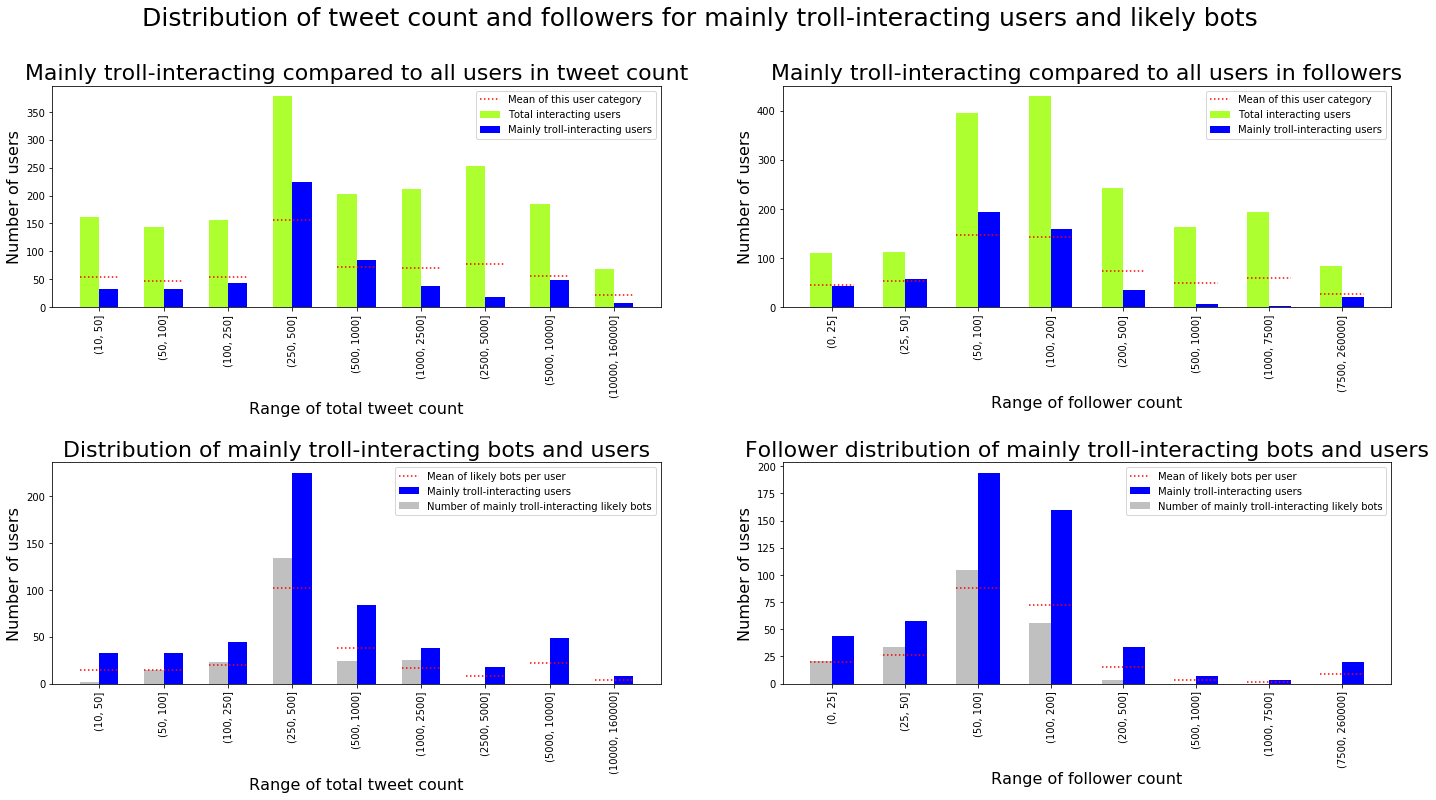

In [854]:
fig, ax = plt.subplots(2, 2, figsize =(24,11))
fig.suptitle("Distribution of tweet count and followers for mainly troll-interacting users and likely bots", fontsize=25)
plt.subplots_adjust(hspace=0.7)
#create a function to plot the interacting users
def plot_interacting_users():
    ax[0][0].bar(np.arange(9), interacting_users_distribution["count(tweetid)"], width, label = "Total interacting users", color = "greenyellow")
    ax[0][1].bar(np.arange(8), interacting_users_followers_distribution["follower_count"], width, label = "Total interacting users", color = "greenyellow")
plot_interacting_users()

ax[0][0].set_title('Mainly troll-interacting compared to all users in tweet count', size=22)
ax[0][1].set_title('Mainly troll-interacting compared to all users in followers', size=22)
ax[1][0].set_title('Distribution of mainly troll-interacting bots and users', size=22)
ax[1][1].set_title('Follower distribution of mainly troll-interacting bots and users', size=22)
#Plot mainly troll interacting users' tweetcount and followers.
plot_basics(ti_users_distribution, tiu_followers_distribution, "Mainly troll-interacting users", "b")
#plot mean taken from the frame over.
plot_category_mean(0.3)
#Plot mainly troll interacting bots' tweetcount and followers. 
plot_bots(tib_distribution, tib_followers_distribution, "Number of mainly troll-interacting likely bots", "silver")
set_labels()

For this category as well i yields that the majority of users lie in certain buckets. It is unlikely for these users to have more than 200 followers, but suddenly there is a bunch of them with over 7500 followers. We know that many of the users are controlled by real persons in the IRA who writes real content (src: https://www.buzzfeednews.com/article/maxseddon/documents-show-how-russias-troll-army-hit-america), and we strongly suspect that many of the users with a lot of followers will have this as a reason. This may explain why many users with 7500 followers or more compared to the range 500 to 7500 is mainly troll-interacting, as they could use the users to boast the follower numbers of other trolls.

We can again see special traits with the likely bots in this category. The bots tweet under 2500 times, and almost every bot over 50 times. These bots never have more than 500 followers, and very rarely over 200.

#### Category 3: Highly interacting users.
Now we are going to take a look at our third category, taking the users that has over 50% interactions in their total tweet count. Again, this does not mean that they tweet interaction tweets in over 50% of their tweets, but almost. Its precise meaning is that the number of users reached in their interaction tweets is over 50% of their total tweets, and that number is as already mentioned almost one-to-one to their total interactions.

Overall, these users are users that mainly retweet, reply or quotes.

In [855]:
#Create tweet distribution for highly interacting users
highly_interacting_users = interactions_en[interactions_en["Interaction_per_tweet_ratio"] >= 0.5][interactions_en["count(tweetid)"] > 10]
hiu_distribution = group_tweetcount(highly_interacting_users, new_ranges)
#Create tweet distribution for highly interacting bots
highly_interacting_bots = bot_users_full[bot_users_full["Interaction_per_tweet_ratio"] >= 0.5]
hib_distribution = group_tweetcount(highly_interacting_bots, new_ranges)
#Create follower distribution for highly interacting users.
hiu_followers = user_followers[user_followers["userid"].isin(highly_interacting_users.index) == True]
hiu_followers_distribution = group_followers(hiu_followers)
#Create follower distribution for highly interacting bots.
hib_followers = user_followers[user_followers["userid"].isin(highly_interacting_bots.index) == True]
hib_followers_distribution = group_followers(hib_followers)

In [749]:
high_interacting_frame = statistics_table(highly_interacting_users, highly_interacting_bots)
add_interactive_frac(high_interacting_frame, highly_interacting_users, highly_interacting_bots)
high_interacting_frame

,Users in this category,Fraction of total users,Fraction of total likely bots,Fraction of interacting users of each user type
User types,,,,
All users,610,0.302,,0.347
Likely bots,196,0.097,0.214,0.260


Highly interacting users account for 30.2% of the dataset, and 9,7% percentage points of these are likely bots. This makes the smallest relative amount of likely bots so far. 34,7% of all interacting useres are in this category.

Of all likely bots 21,4 % is likely bots from this category, and 26% of all interacting bots are this category.

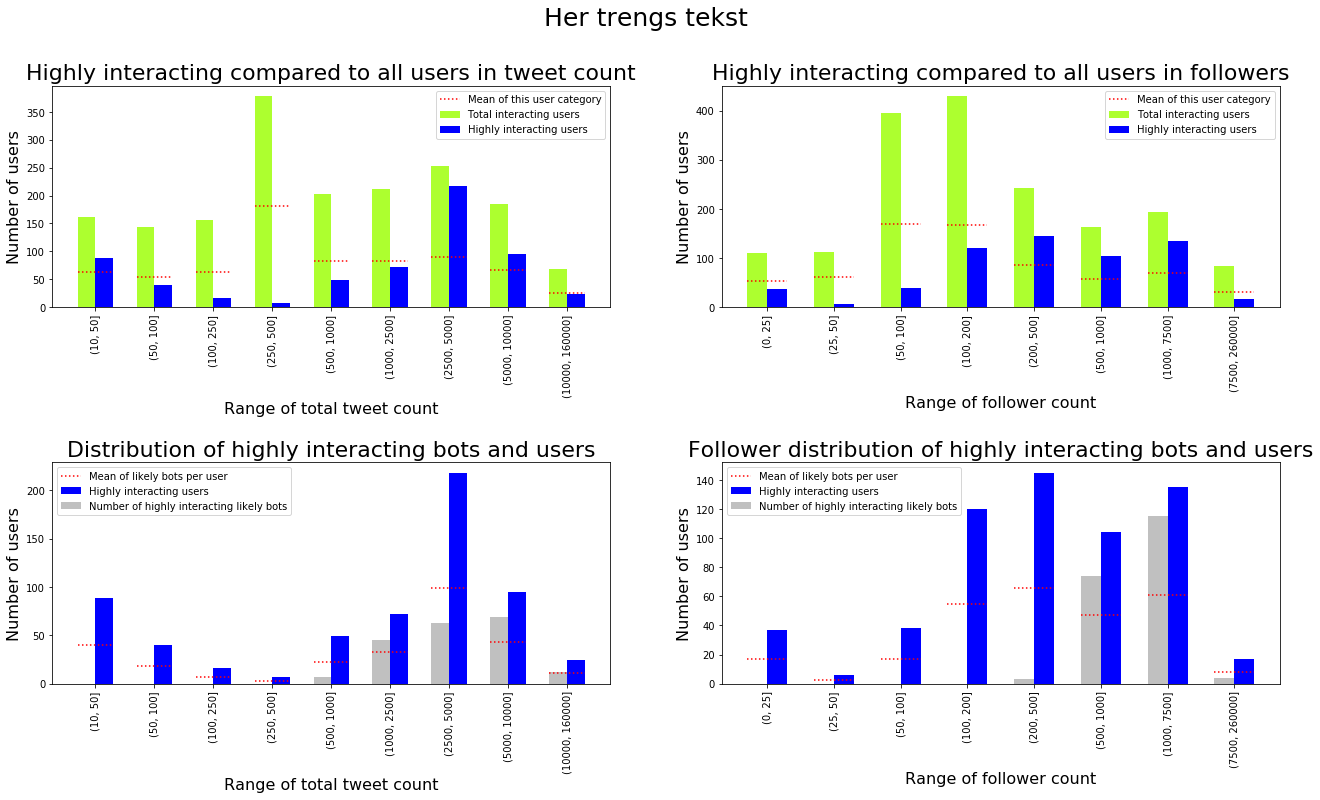

In [691]:
fig, ax = plt.subplots(2, 2, figsize =(22,11))
fig.suptitle("Her trengs tekst", fontsize=25)
plt.subplots_adjust(hspace=0.7)

ax[0][0].set_title('Highly interacting compared to all users in tweet count', size=22)
ax[0][1].set_title('Highly interacting compared to all users in followers', size=22)
ax[1][0].set_title('Distribution of highly interacting bots and users', size=22)
ax[1][1].set_title('Follower distribution of highly interacting bots and users', size=22)

#Plot the same interacting users as in the last visualization.
plot_interacting_users()
#Plot tweetcount and follower distribution of highly interacting users.
plot_basics(hiu_distribution, hiu_followers_distribution, "Highly interacting users", "b")  
#the percentage multiplier is taken from the cell over.
plot_category_mean(0.35)
#Plot tweetcount and follower distribution of highly interacting bots.
plot_bots(hib_distribution, hib_followers_distribution, "Number of highly interacting likely bots", "silver")
set_labels()

Here we can see numerous different traits for both the highly interacting users and bots. Except a number of highly interacting users with very few tweets, the high numbers of tweet count dominates, with the range between 2500 and 5000 tweets being almost exclusively highly interacting users. It seems like the trend is that when the users first start with interactions, they interact a lot. This user category generally has a relatively high follower distribution as well, themost found in the range between 100 and 7500 followers, with the range between 200 and 7500 being the one that dominates the most.

For the highly interacting likely bots, they never have a tweet count on under 500, and mainly over 1000. The follower distribution of those is also limited, we can see that none has under 200 followers, and almost every user has between 500 and 7500. The number of bots with followers over 7500 is also not unsignificant compared to the highly interacting users, but in total they make up a very little part of the users.

#### Category 4: Highly interacting users that mainly interact to other trolls.
Now we want to combine the two categories and look at the users that interact a lot and also mainly interact with other trolls. This is a union category of the two last categories, and will show the users that overlap the two last categories.

In [601]:
#Create frame with tweetcount distribution of highly interacting mainly troll-interacting users.
high_interact_and_high_troll_interact = highly_interacting_users[highly_interacting_users["Ratio_interaction_with_trolls"] >= 0.5]
hiah_distribution = group_tweetcount(high_interact_and_high_troll_interact, new_ranges)
#Create frame with tweetcount distribution of highly interacting mainly troll-interacting bots.
high_interact_and_high_troll_interact_bots = highly_interacting_bots[highly_interacting_bots["Ratio_interaction_with_trolls"] >= 0.5]
#this actually becomes none users.
hiah_bot_distribution = group_tweetcount(high_interact_and_high_troll_interact_bots, new_ranges)
#Create frame with follower distribution of highly interacting mainly troll-interacting users.
high_interact_and_high_troll_interact_followers = user_followers[user_followers["userid"].isin(high_interact_and_high_troll_interact.index) == True]
hiahti_followers_distribution = group_followers(high_interact_and_high_troll_interact_followers)
#since there are zero likely bots in this category we don't consider taking their follower number and plotting it.


In [750]:
high_interacting_trolls_frame = statistics_table(high_interact_and_high_troll_interact, high_interact_and_high_troll_interact_bots)
high_interacting_trolls_frame

,Users in this category,Fraction of total users,Fraction of total likely bots
User types,,,
All users,80,0.04,
Likely bots,0,0.00,0.0


Highly troll-interacting users account for only 4% of the dataset, so it is a small category.
Surprisingly there are no likely bots in this category, but there might be a logical explanation behind this. Our theory is that if you want users that mainly interact and interacts mostly with other trolls !!fortsetta:

Since there was none likely bots in this category, we are going to compare those users against the users that did not fall under the users that interact with people more than 50% in their tweets to see how they fit in in this category. We will not be comparing the bots in this case since there are zero bots.

In [856]:
#Create a follower and tweetcount distribution of the followers of only non-likely bots.
only_non_bots_followers = hiu_followers_distribution.sub(hib_followers_distribution)
only_non_bots_user = hiu_distribution.sub(hib_distribution)

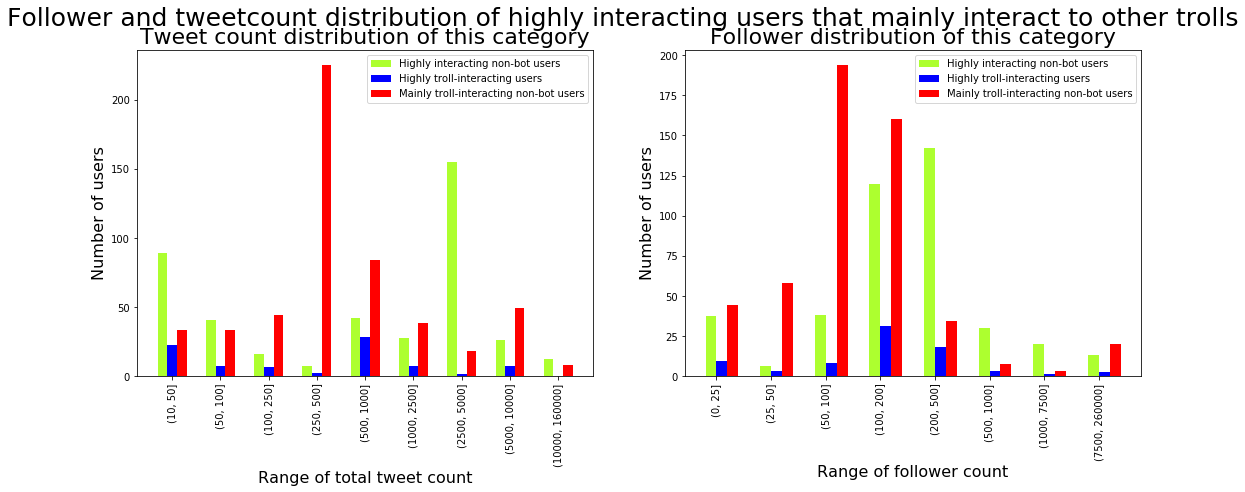

In [866]:
fig, ax = plt.subplots(1, 2, figsize =(18,6))
fig.suptitle("Follower and tweetcount distribution of highly interacting users that mainly interact to other trolls", fontsize=25)
plt.subplots_adjust(hspace=0.9)
width=0.2
#plot non-likely bots follower and tweetcount distribution.
ax[0].bar(np.arange(9), only_non_bots_user["count(tweetid)"], width, label = "Highly interacting non-bot users", color = "greenyellow")
ax[1].bar(np.arange(8), only_non_bots_followers["follower_count"], width, label = "Highly interacting non-bot users", color = "greenyellow")
ax[1].set_title('Follower distribution of this category', size=22)
ax[0].set_xlabel("Range of total tweet count", size=16)
ax[1].set_xlabel("Range of follower count", size=16)
ax[0].set_ylabel("Number of users", size=16)
ax[1].set_ylabel("Number of users", size=16)
ax[0].set_xticks(np.arange(9) + width)
#Plot follower and tweetcount distribution of Highly interacting users that mainly interact to other trolls
ax[0].bar(np.arange(9) + width, hiah_distribution["count(tweetid)"], width, label = "Highly troll-interacting users", color = "b")
ax[0].bar(np.arange(9) + width*2, ti_users_distribution["count(tweetid)"], width, label = "Mainly troll-interacting non-bot users", color = "r")
ax[1].set_xticks(np.arange(8) + width/2)
ax[0].set_title('Tweet count distribution of this category', size=22)
ax[1].bar(np.arange(8)+width, hiahti_followers_distribution["follower_count"], width, label = "Highly troll-interacting users", color = "b")
ax[1].bar(np.arange(8) + width*2, tiu_followers_distribution["follower_count"], width, label = "Mainly troll-interacting non-bot users", color = "r")
ax[0].set_xticklabels(ientc_dist_over_ten.index, rotation=90)
ax[1].set_xticklabels(user_followers_dist.index, rotation=90)
ax[0].legend()
ax[1].legend()

The details given from the users don't provide us that much information. Their follower distribution mainly follow the norm, and the sample size is so small so the differences does not tell us something. Though, most of the reason why the numbers are so low we can see that the red and green bars do not overlap, but rather stands out as their own spikes. We can see that the blue line often is close to it's smallest neighbor. 

Overall this do not provide more information than that the highly interacting users and the mainly troll-interacting users are spread differently in tweet count and followers.

The two users with most followers are WarfareWW (Unknown), with 33000. The user reports war news but foremost interacting with other trolls. Number two is TrayneshaCole, LeftTroll with 25000 followers. This user was also on the list of users that had the most interactions from all users on Twitter. It is therefore surprising to see that this user has so many interaction tweets, and that they mainly go toward trolls, when it has so high amount of normal Twitter users interacting with it.

Since we had no likely bots in this category we are going to visualize the distribution of troll-interacting likely bots and highly interacting bots to the distribution of bots overall:

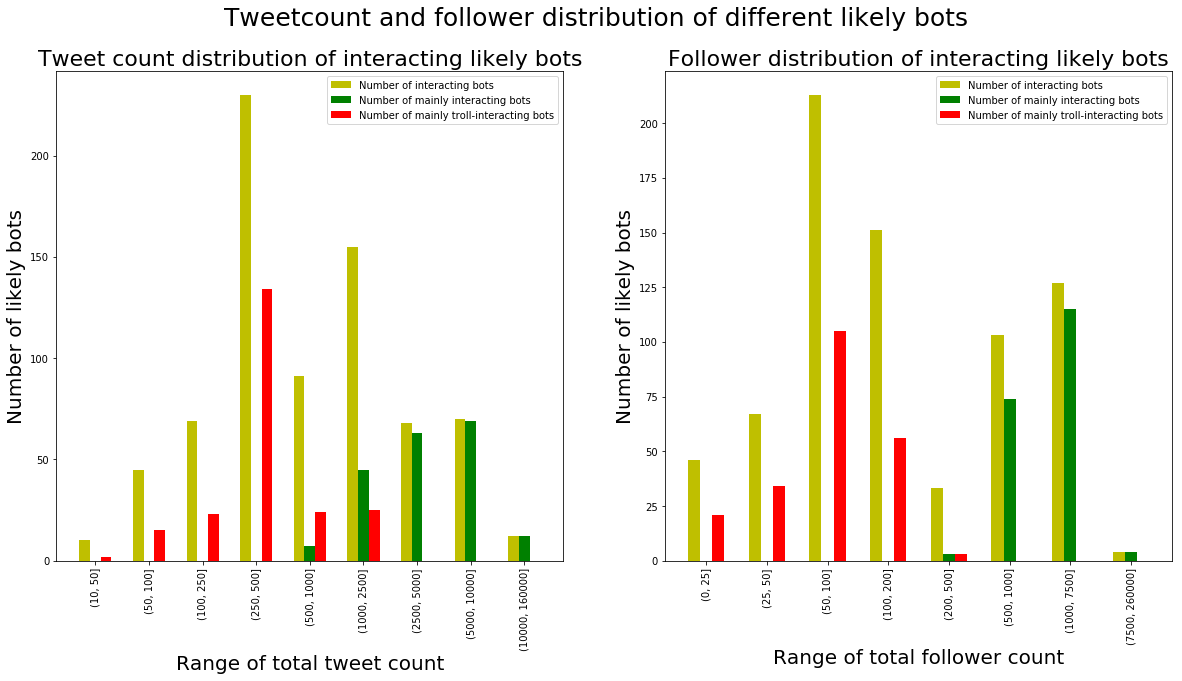

In [868]:
fig, ax = plt.subplots(1, 2, figsize =(20,9))
fig.suptitle("Tweetcount and follower distribution of different likely bots", fontsize=25)

#plot first chart
ax[0].set_title('Tweet count distribution of interacting likely bots', size=22)
ax[0].set_xlabel("Range of total tweet count", size=20)
ax[0].set_ylabel("Number of likely bots", size=20)
#set width for each bar.
width = 0.2
ax[0].set_xticks(np.arange(9) + width)
ax[0].set_xticklabels(interacting_bots_distribution.index, rotation=90)

ax[0].bar(np.arange(9), interacting_bots_distribution["count(tweetid)"], width, label = "Number of interacting bots", color = "y")
ax[0].bar(np.arange(9) + width, hib_distribution["count(tweetid)"], width, label = "Number of mainly interacting bots", color = "green")
ax[0].bar(np.arange(9) + width*2, tib_distribution["count(tweetid)"], width,  label = "Number of mainly troll-interacting bots", color = "r")
ax[0].legend()

#plot second chart with followers:
ax[1].bar(np.arange(8), interacting_bots_followers_distribution["follower_count"], width, label = "Number of interacting bots", color = "y")
ax[1].bar(np.arange(8) + width, hib_followers_distribution["follower_count"], width, label = "Number of mainly interacting bots", color = "green")
ax[1].bar(np.arange(8) + width*2, tib_followers_distribution["follower_count"], width, label = "Number of mainly troll-interacting bots", color = "r")
ax[1].set_xticks(np.arange(8) + width)
ax[1].set_xticklabels(interacting_bots_followers_distribution.index, rotation=90)
name_axises("Follower distribution of interacting likely bots","Range of total follower count" , "Number of likely bots")
ax[1].legend()

Here we can see that the likely bots almost has a perfectly diving line in both followers and tweet count. Almost all of the likely bots that interact at all are mainly interacting bots. The same accounts with the bots that interact at all over 500 followers.

This means that the likely bots that mainly interacts with other users tweets an enormous part. They also have a lot of followers which we may suppose that comes from the extreme amount of interacting with other normal Twitter users. They may also have bot-like behaviour when it comes to following others. 

That the bots that mainly interact with other trolls has a small amount of followers is not surprising since they mostly don't reach out to other users and tweet in limited numbers.

#### Category 5: Non-categorized users.

So we are left with a number of non-categorized users so far. They do have certain traits, they have under 50% of their interactions to other trolls, they have interactions less than 50% in their tweets and they can be interacting with other users. However, these traits are just normal behaviour from users so it does not make them special in any format. How will their distribution look now? In this part we are going to look at them compared to all of total impacting users, as in the plot with non-impacting users.

In [869]:
# Create distribution of tweet count of non categorized users.
total_noncat_users = interactions_en[interactions_en["Ratio_interaction_with_trolls"] < 0.5][interactions_en["count(tweetid)"] > 10][interactions_en["Interaction_per_tweet_ratio"] < 0.5]
tnu_distribution = group_tweetcount(total_noncat_users, new_ranges)
## Create distribution of tweet count of non categorized bots.
total_noncat_bots = bot_users_full[bot_users_full["Ratio_interaction_with_trolls"] < 0.5][bot_users_full["Interaction_per_tweet_ratio"] < 0.5]
tnb_distribution = group_tweetcount(total_noncat_bots, new_ranges)
## Create distribution of followers of non categorized users.
tnu_followers = user_followers[user_followers["userid"].isin(total_noncat_users.index) == True]
tnu_followers_distribution = group_followers(tnu_followers)
## Create distribution of followers of non categorized bots.
tnb_followers = user_followers[user_followers["userid"].isin(total_noncat_bots.index) == True]
tnb_followers_distribution = group_followers(tnb_followers)


In [751]:
non_categorized_frame = statistics_table(total_noncat_users, total_noncat_bots)
non_categorized_frame

,Users in this category,Fraction of total users,Fraction of total likely bots
User types,,,
All users,697,0.345,
Likely bots,331,0.164,0.361


Non-categorized users account for 34.5% of the dataset, and 16,4% percentage points of these are likely bots.
Of all likely bots 36,1 % is likely bots from this category, making it the larges category both for total users and likely bots, but not for non-likely bots. There the largest category is highly interacting users.

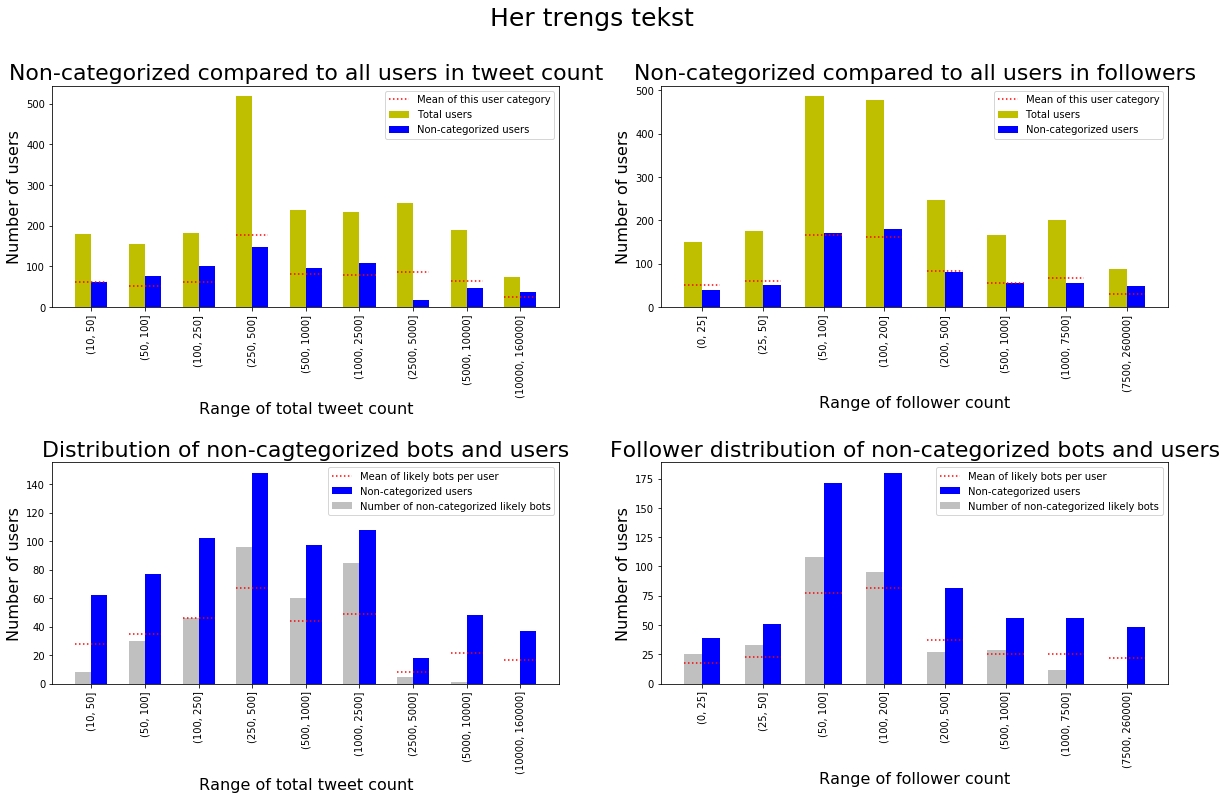

In [745]:
fig, ax = plt.subplots(2, 2, figsize =(20,11))
fig.suptitle("Her trengs tekst", fontsize=25)
plt.subplots_adjust(hspace=0.7)

width=0.3
ax[0][0].set_title('Non-categorized compared to all users in tweet count', size=22)
ax[0][1].set_title('Non-categorized compared to all users in followers', size=22)
ax[1][0].set_title('Distribution of non-cagtegorized bots and users', size=22)
ax[1][1].set_title('Follower distribution of non-categorized bots and users', size=22)
ax[0][0].bar(np.arange(9), ientc_dist_over_ten["count(tweetid)"], width, label = "Total users", color = "y")
ax[0][1].bar(np.arange(8), user_followers_dist["follower_count"], width, label = "Total users", color = "y")
plot_basics(tnu_distribution, tnu_followers_distribution, "Non-categorized users", "b")
plot_category_mean(0.34)
plot_bots(tnb_distribution, tnb_followers_distribution, "Number of non-categorized likely bots", "silver")
set_labels()


In non-categorized users compared to all users in tweetcount and followers we don't really see anything special. We have categorized almost every user in the tweet count range (2500,5000], but this may be a coincidence. It is almost strangely uniformly distributed to the mean in follower count.

We can see that we have not categorized so many of the likely bots in the "middle distributions", but every likely bot with the highest amount of followers and tweet count has been categorized as something. As we can remember for earlier analysis, they did not count for most of the users in the category, but it seems like those were pretty easy to pick out.

So, here is our final table with all of our categorized users. Remember that the highly troll-interacting users is a union of the two categories over it in the table.

In [871]:
final_table = pd.concat([non_interacting_frame, main_troll_interacting_frame, high_interacting_frame, high_interacting_trolls_frame, non_categorized_frame], axis=0).drop(columns="Fraction of interacting users of each user type")
cols = ["Users in this category", "Fraction of total users", "Fraction of total likely bots"]
final_table = final_table[cols]
final_table["User categories"] = ["Non-interacting users:", "Non-interacting users:", "Mainly troll-interacting users:", "Mainly troll-interacting users:", "Highly interacting users:", "Highly interacting users:", "Highly interacting users that mainly interact to trolls:", "Highly interacting users that mainly interact to trolls:", "Non-categorized users:", "Non-categorized users:"]
table_index1 = final_table["User categories"].tolist()
final_table["User types"] = final_table.index.tolist()
table_index2 = final_table[["User types"]].index.tolist()
final_table = final_table.set_index(["User categories", "User types"])
final_table
                                  

Users in this category  \
User categories                                    User types                            
Non-interacting users:                             All users                       264   
                                                   Likely bots                     168   
Mainly troll-interacting users:                    All users                       532   
                                                   Likely bots                     223   
Highly interacting users:                          All users                       610   
                                                   Likely bots                     196   
Highly interacting users that mainly interact t... All users                        80   
                                                   Likely bots                       0   
Non-categorized users:                             All users                       697   
                                                   Likely bots                     331   

                                                                Fraction of total users  \
User categories                                    User types                             
Non-interacting users:                             All users                      0.130   
                                                   Likely bots                    0.083   
Mainly troll-interacting users:                    All users                      0.263   
                                                   Likely bots                    0.110   
Highly interacting users:                          All users                      0.302   
                                                   Likely bots                    0.097   
Highly interacting users that mainly interact t... All users                      0.040   
                                                   Likely bots                    0.000   
Non-categorized users:                             All users                      0.345   
                                                   Likely bots                    0.164   

                                                               Fraction of total likely bots  
User categories                                    User types                                 
Non-interacting users:                             All users                                  
                                                   Likely bots                         0.183  
Mainly troll-interacting users:                    All users                                  
                                                   Likely bots                         0.243  
Highly interacting users:                          All users                                  
                                                   Likely bots                         0.214  
Highly interacting users that mainly interact t... All users                                  
                                                   Likely bots                           0.0  
Non-categorized users:                             All users                                  
                                                   Likely bots                         0.361

We also made the same table in plotly to make it more colorful.

In [872]:
trace = go.Table(
    header=dict(values=['User categories', 'User types', 'Users in this category', 'Fraction of total users', 'Fraction of total likely bots'],
                line = dict(color='#7D7F80'),
                fill = dict(color='#a1c3d1'),
                align = ['left'] * 5),
    cells=dict(values=[table_index1, table_index2,
                      final_table["Users in this category"], final_table["Fraction of total users"], final_table["Fraction of total likely bots"]],
               line = dict(color='#7D7F80'),
               fill = dict(color='#EDFAFF'),
               align = ['left'] * 5))
layout = dict(width=800, height=1000)
data = [trace]
fig = dict(data=data, layout=layout)
py.iplot(fig, filename = 'styled_table')

### 3.5 Is there a way for people to detect whether a Twitter user is a russian troll?

Finally we are going to try to answer this question, and use the categories to give us insight in this. In general, the answer to this question is no, unfortunately. Most Twitter users do not have time or don't take the effort to detect some of the trolls. In no cases can you be sure of that it represents a troll from the IRA as well, but you may be able to detect whether this user is a troll in general! Let's have a look at the final table again:

In [873]:
final_table

Users in this category  \
User categories                                    User types                            
Non-interacting users:                             All users                       264   
                                                   Likely bots                     168   
Mainly troll-interacting users:                    All users                       532   
                                                   Likely bots                     223   
Highly interacting users:                          All users                       610   
                                                   Likely bots                     196   
Highly interacting users that mainly interact t... All users                        80   
                                                   Likely bots                       0   
Non-categorized users:                             All users                       697   
                                                   Likely bots                     331   

                                                                Fraction of total users  \
User categories                                    User types                             
Non-interacting users:                             All users                      0.130   
                                                   Likely bots                    0.083   
Mainly troll-interacting users:                    All users                      0.263   
                                                   Likely bots                    0.110   
Highly interacting users:                          All users                      0.302   
                                                   Likely bots                    0.097   
Highly interacting users that mainly interact t... All users                      0.040   
                                                   Likely bots                    0.000   
Non-categorized users:                             All users                      0.345   
                                                   Likely bots                    0.164   

                                                               Fraction of total likely bots  
User categories                                    User types                                 
Non-interacting users:                             All users                                  
                                                   Likely bots                         0.183  
Mainly troll-interacting users:                    All users                                  
                                                   Likely bots                         0.243  
Highly interacting users:                          All users                                  
                                                   Likely bots                         0.214  
Highly interacting users that mainly interact t... All users                                  
                                                   Likely bots                           0.0  
Non-categorized users:                             All users                                  
                                                   Likely bots                         0.361

A review of each category, can you detect these trolls?
A review of each category, can you detect these trolls? In all of these visualizations the number of users include bots and non-bots.

- **Non-interacting non-bots**: Around 4.7 % of the users in the dataset. They have few followers and do not tweet much. You will probably never be in touch with these since they have such small impact on the overall discussion on Twitter. How can you detect these as trolls? There is probably nothing special about their tweets and can not be detected by just looking into the profile or tweets, but one could try to reply to one of their original tweets with a question if you suspect a troll. You will probably not get an answer.


- **Non-interacting bots**: Around 8,3 % of the dataset. They have exclusively few followers and have a medium amount of tweets, but never more than 2500. These are probably the easiest to detect. You could easily search for the same content (take something with a significant length) in the Twitter search option and find numerous other encounters of the same tweet. You could also look at its feed and see that it has a really monotonic way of tweeting. In addition you could also apply the same tactic as over and wait for an answer, though it might be that some of them have the feature of answering. Try asking a complicated one in that case.


- **Mainly troll-interacting non-bots**: Around 26,3% of the dataset. Mainly pretty evenly distributed, but few of them have many followers, though they make up a good amount of the users with most followers. They have a average amount of tweets. If you are able to know whether other users are trolls, you could find patterns in this users way of interacting with others. As a normal Twitter user however, it seems rather hard to tell if it is in this category. These users mainly have not a big impact, but among the user with most followers they are very effective for their purpose by exploiting the fact that they have many followers to advert for other Twitter trolls and make them more noticed by retweeting and quote tweeting. This probably makes them one of the more dangerous categories.


- **Mainly troll-interacting bots**: Around 11% of the dataset falls in this category. Has a medium distribution of total tweets, never over 2500. Always a low amount of followers, almost exclusively under 200. One can use the same tactic as with all bots, search for their original content and look for numerous other encounters. Again it would be difficult regarding whether you know how other users are trolls, but since they make up around 50% of all interacting bots with under 200 followers, this may be a way to detect other twitter trolls.


- **Highly interacting non-bots**: Around 20% of all user in the dataset is in this category. Have a small amount of users in the medium range (100 to 1000) of total tweets and make up a significant number of those with a small amount of tweets and semi-high amount of around 2500 to 5000 tweets. Those users are hard to detect as trolls compared to other users that interact a lot, but you should have a natural skepticism towards users that mainly interacts in form of just forwarding other messages in form of retweeting and quoting.In case of followers most of them have medium amount of between 100 and 500, but are represented in all the ranges. Some of them may be retweet bots that convey a specific political standpoint, but overall it is users that would avoid being recognized as trolls.


- **Highly interacting bots**: Around 9.7% of all users in the dataset is in this category. Exclusively have more than 500 tweets, mostly over 1000. They always have a high amount of followers, mostly being between 500 and 7500 followers where they make up over 50% of all interacting users. Since they have so specific common traits, these users can be picked up as trolls if you have a keen eye. Look for their original content and check whether it is duplicates using the same methods as earlier mentioned 


- **Highly interacting non-bots that mainly interact to trolls**: This category is an overlap of the two abovementioned categories. Around 4% of all users in the dataset is in this category, and 4 percentage points of the users in each the categories over except none-interacting users. They are pretty evenly distributed in terms of both total tweets and followers. The same yields for these users as the two mentioned in case of detection. They are slightly easier to point out, but unfortunately, it is still hard for a common Twitter user.


- **Highly interacting bots that mainly interact to trolls**: These users do not exist so far. Probably because it easily could be picked up on by algorithms if the only thing you do as a Twitter user would be to interact with only a specific number of users with a bot-like pattern.


- **Non-categorized non-bots**: Around 18,1% of all users. They do have the traits that the other categories don’t have, but this only makes them looking like normal twitter users. They are evenly distributed in terms of both total tweets and followers, but they make up the majority of total users with more than 10000 tweets and 7500 followers. This means that these users are the ones that has the most impact on the general discussion on Twitter, and reaches the broadest amount of people. It is very likely that these are the users that are seen by IRA as the main communicators of opinions, and have a very high chance of being fully controlled by real humans, as we know a number of the users are. This link provides insight in this claim https://www.buzzfeednews.com/article/maxseddon/documents-show-how-russias-troll-army-hit-america.


- **Non-categorized bots**:  Around 16,4% of all users. They rarely have more than 2500 tweets but account for around a third of the users between 1000 and 2500 tweets. In terms of followers they are mostly limited to under 200, and do not exist in the group of users with over 7500 followers. Unfortunately, there is no way to detect these users except the method that applies for all bots. Search for their original content of significant length, and look for numerous duplicates.


# 4) Discussion of our project.

## 4.1) Critique of own analysis and sources of potential error

For many of our tasks it is unclear whether one can say that this is an total accurate representation of russian meddling on twitter. We only have a data sample, and it is likely that some of these accounts were taken down, given up on by IRA or by other reasons are not as active through the total period. In, it shows a general trend of the activity.

We strongly emphasize that our division of the users into likely bots has the word LIKELY. This categorization does not mean that these users are bots, but the probability for it being a bot is quite high in our opinion.

The classification of the total interactions are a bit confusing. It is difficult to think of it as something else as that one interaction is one tweet, when it can in some instances be two interactions in one tweet. We evaluated limiting two interactions as one, but we also felt that this did not justify the amount of interactions.

The categorization of users and the distribution of them in buckets and tweet counts does not take into account where those users are when they are "up-and-coming". Every user has to start with one tweet, and this categorization is taking base in the point where the users have tweeted their last tweet.


## 4.2) Own thoughts of the project.


### 4.2.1) Thoughts regarding the data sets

**First dataset:**
The first data set had some features that initally was thought to be useful that ended up not being so much, especially region and language. This encoding was not fully correct, and we therefore had to use them much more careful than earlier believed. 

**Second dataset:**

Things got a little changed when we got the possibility to work with a second data set on Sunday 18th November. The new data set featured a bunch of new interesting features, as well as not being categorized in the same manner as the first. We were able to a lot more analysis on features like how they interact.

The number of quote tweets, retweets and replies each user has on their tweet may in most cases be correct, but they are so often that it is hard to use them for a total correct analysis.

### 4.2.2) Dropped ideas or changed approaches to them.

**Other languages**

We worked a while on trying to analyse some of the non-english tweets, in particular the european ones. It was a significant amount, especially of the german data, but we struggled to get something in particular out of it. In general text classification became harder than initially thought. 

**General text classification** 

We was originally going to do this regarding the question how someone could determine whethter a twitter account is a troll. We knew that the TextBlob library had the application to create a sentiment, subjectivity and polarization tweets. We applied this, but when we were visualizing it we found out that it did not work as we had hoped. We found out that many of the tweets were not giving values even though there were clear indication of negative speak or positive speak. We also saw that the library struggled when tweets were particulary short. This led to our decision of dropping this, since the results given did not really give a right view of the content of the dataset.

**Concerning traits to look for whether a user is a troll**

We found out that many of the twitter users have irregular rhytms when it comes to followers and the update of them after tweeting. Some had sudden drops of hundreds of followers and following in just a few minutes, which may imply buying of fake or real followers (or own methods of phishing to get them). Others had irregular amounts of tweets in short time span, and also some users were sharing the same rhythm of the same tweets. Unfortunately, in the datasets, there are a lot of time stamps that do not make sense. For example the number of updates are not matching the time of the tweet. The updates follows a chronological order, then it suddenly switches back hours, months and even years. Before it follows chronogical order again. This occurs with a frequency that made it really hard to analyze.

If we had done everything again we would probably do more of the initial analysis on the second dataset rather than the first, but this was prioritized down in our project.

# 5) Further work

Create the poster:
- Sort out the visuals that works best in paper format, and choose the most interesting results for this.

Thanks for reading!